# Projet Optimisation et Apprentissage

L'objectif de ce projet est d'implémenter les différents modèles de programmation linéaire en variables mixtes vus en cours pour les *Support Vector Machine* (SVM) pour la séparation de points en deux dimensions.

**Remarque :** Comme vu en cours, nous utiliserons la norme 1 dans la fonction objective pour les différents modèles.

## Attendu pour ce projet

1. Générer un dataset composé de 20 points 2D aléatoires. Chaque point aura un label parmi $\{-1,1\}$ de telle manière que :
      * chaque classe a le même nombre de points,
      * les points sont linéairement séparables. 
2. Implémenter le problème d'optimisation linéaire déterminant l'hyperplan optimal et donner l'équation de cet hyperplan.
3. Modifier le label de 5 points afin de rendre ce dataset non linéairement séparable.
4. Implémenter deux modèles vus en cours (selon les losses choisies : *hinge*, *Ramp* ou *Hard margin*) permettant d'obtenir les hyperplans optimaux. Donner les deux hyperplans obtenus.
5. Comparer et discuter les résultats obtenus par les différents modèles.

**Optionnel :** 
* Vous pouvez ajouter des figures (générées avec `mathplotlib` par exemple) pour illustrer les hyperplans obtenus.
* Vous pouvez évaluer l'impact de la variation de la pondération $C$ utilisée dans les losses.
* Vous pouvez tester sur un dataset plus important.

Le projet doit être un fichier notebook python contenant les modèles et les résultats. Des images/photos peuvent être insérées dans ce fichier. 
Ce dernier doit être envoyé par mail à **lacroix@lipn.fr** avant le **9 mars 2025**.

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/auduvignac/SVM_optimisation/blob/main/SVM-Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

## Question 1.
Générer un dataset composé de 20 points 2D aléatoires. Chaque point aura un label parmi $\{-1,1\}$ de telle manière que :
 - chaque classe a le même nombre de points,
 - les points sont linéairement séparables.

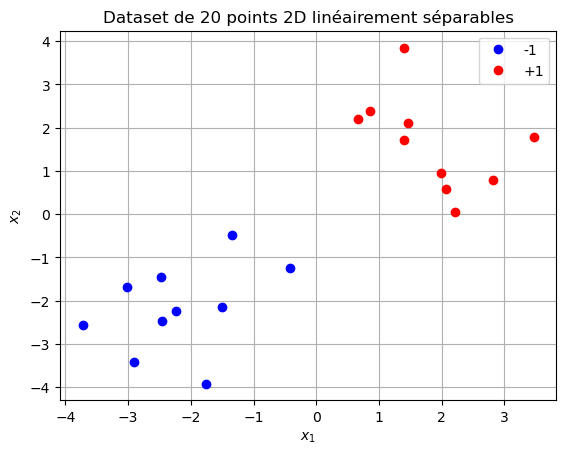

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Fixer la graine aléatoire pour reproductibilité
np.random.seed(42)

# Générer 10 points pour la classe -1
class_neg = np.random.randn(10, 2) - 2  # Décaler pour séparer les classes

# Générer 10 points pour la classe 1
class_pos = np.random.randn(10, 2) + 2  # Décaler pour séparer les classes

# Ajouter les labels
labels_neg = -np.ones(10)
labels_pos = np.ones(10)

# Combiner les points et les labels
points = np.vstack((class_neg, class_pos))
labels = np.hstack((labels_neg, labels_pos))

# Mélanger les points et les labels
indices = np.arange(20)
np.random.shuffle(indices)
points = points[indices]
labels = labels[indices]

# Afficher les points
plt.plot(
    points[:, 0][labels == -1], points[:, 1][labels == -1], "bo", label="-1"
)  # Cercles bleus pour -1
plt.plot(
    points[:, 0][labels == 1], points[:, 1][labels == 1], "ro", label="+1"
)  # Cercles rouges pour +1
plt.title("Dataset de 20 points 2D linéairement séparables")
plt.xlabel(r"$x_{1}$")
plt.ylabel(r"$x_{2}$")
plt.grid()
plt.legend()
plt.show()

## Question 2.
Implémenter le problème d'optimisation linéaire déterminant l'hyperplan optimal et donner l'équation de cet hyperplan.

### Rappels concernant l'expression de la distance minimale dans le cadre de la formulation du problème d'optimisation de la SVM

Le schéma ci-dessous illustre la formulation du problème d'optimisation de la SVM entraînée sur deux classes. Les échantillons situés sur les marges sont appelés vecteurs de support.
Plusieurs éléments apparaissent sur le schéma :
- les marges en bleu et rouges qui sont les droites parallèles à l'hyperplan optimal et passant par les vecteurs de support;
- l'hyperplan optimal permettant de séparer les deux classes en rouge, dont l'expression est $w^{T} x + b = 0$

<img src="https://raw.githubusercontent.com/auduvignac/SVM_optimisation/refs/heads/main/Figures/rapport/SVM_schema.png">

Par définition :
- Soit $H$ l'hyperplan optimal séparant les deux classes. Pour tout point $x_{H}$ appartenant à cet hyperplan et $w$ un vecteur orthogonal à $H$, nous avons $w^{T} x_{H} + b = 0$ ;
- Soit $x_{+}$ (respectivement $x_{-}$) les vecteurs appartenant à la classe $+1$ (respectivement $-1$), nous avons : $w^{T} x_{+} + b \geq +1$ et $w^{T} x_{-} + b \leq -1$ ;
- Soit $y_{i} \; \forall i \in [1; n]$, les labels associés aux vecteurs $x_{i}$, nous avons : $y_{i} (w^{T} x_{i} + b) \geq +1$.

En décomposant un vecteur x selon $x_{H} \in H$ et le vecteur $w$, nous avons : $x = x_{H} + d(x, H) \cdot w$, ce qui équivaut à dire que $x_{H} = x - d(x, H) \cdot w$.

<img src="https://raw.githubusercontent.com/auduvignac/SVM_optimisation/refs/heads/main/Figures/rapport/SVM_schema_projection_x.png">

En injectant cette expression dans l'équation de l'hyperplan, nous obtenons : $w^{T} (x - d(x, H) \cdot w) + b = 0$.

Ainsi, nous avons : $w^{T} x - d(x, H) \cdot w^{T} w + b = 0$.

En notant $w^{T} w = \|w\|_{L_{k}}$ pour $k \in \{1, 2\}$, nous obtenons : $d(x, H) = \frac{w^{T} x + b}{\|w\|_{L_{k}}}$.

Ici, $L_{k}$ représente la norme $k$ pour $k \in \{1, 2\}$ :
- $L_{1}$ correspond à la norme 1 qui s'exprime comme $\|w\|_{L_{1}} = \sum\limits_{i=1}^{n} |w_{j}|$ ;
- $L_{2}$ correspond à la norme 2 qui s'exprime comme $\|w\|_{L_{2}} = \sum\limits_{i=1}^{n} w_{j}^{2}$.

Dans le cadre de ce projet nous utiliserons la norme 1 pour une formulation MILP (Mixed Integer Linear Programming : Optimisation linéaire en nombres entiers) dont la forme canonique est la suivante :

$$
\begin{aligned}
& \underset{\mathbf{x}}{\text{minimiser}}
& & \mathbf{c}^{T} \mathbf{x} \\
& \text{sous les contraintes}
& & A \mathbf{x} \leq \mathbf{b}
\end{aligned}
$$


L'objectif de la SVM est de maximiser la marge entre les deux classes, c'est à dire maximiser la distance minimale entre les points et l'hyperplan optimal. Cela peut s'exprimer comme suit :
$$
\begin{aligned}
& \underset{w, b}{\text{maximiser}}
& & \frac{2}{\|w\|_{L_{1}}} \\
& \text{sous les contraintes}
& & y_{i} (w^{T} x_{i} + b) \geq 1, \quad \forall i \in [1; n]
\end{aligned}
$$

Ce qui en revient à minimiser $\frac{1}{2} \|w\|_{L_{1}}$ sous les contraintes $y_{i} (w^{T} x_{i} + b) \geq 1, \quad \forall i \in [1; n]$.

Dans la suite, pour simplifier l'écriture, nous noterons la norme $k$ de $w$ par $\|w\|_{k}$ pour $k \in \{1, 2\}$.

### Rappels concernant la formulation du problème d'optimisation de la SVM à marge rigide classique et reformulation.

Nous cherchons à résoudre le problème d'optimisation suivant (nous noterons $k$ la régularisation associée à la norme $k$ pour $k \in \{1, 2\}$) :

$$
\begin{aligned}
& \underset{\mathbf{w} \in \mathbb{R}^{p}, b \in \mathbb{R}}{\text{minimiser}}
& & \frac{1}{2} \|\mathbf{w}\|_{k} \\
& \text{sous les contraintes}
& & y_i (\mathbf{w}^T \mathbf{x}_i + b) \geq 1, \quad \forall i \in \{1, \ldots, n\}
\end{aligned}
$$

En l'occurrence $p = 3$, $n = 20$ et $k=1$ (*i.e.* la norme 1 qui s'exprime comme $\|\mathbf{w}\|_{1} = \sum\limits_{j=1}^{p} |w_j|$).

De plus, étant donné que les points $x_{i}$ s'exprime par l'intermédiaire de deux coordonnées que nous noterons $x_{1, i}$ et $x_{2, i}$ associées respectivement à l'abscisse et à l'ordonnée de $x_{i}$ et que $w = [w_{1}, w_{2}]$, nous avons : $w^{T} \mathbf{x}_i = w_{1} x_{1, i} + w_{2} x_{2, i}$.
Ainsi, nous pouvons réécrire le problème précédent comme suit :

$$
\begin{aligned}
& \underset{\mathbf{w}, b}{\text{minimiser}}
& & \frac{1}{2} \| \mathbf{w} \|_1 \\
& \text{sous les contraintes}
& & y_i (w_{1} x_{1, i} + w_{2} x_{2, i} + b) \geq 1, \quad \forall i \in \{1, \ldots, n\}
\end{aligned}
$$
Pour une cohérence d'écriture, nous noterons le biais $b$ par $w_{3}$ et $x_{i, 3} = 1$.

$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{minimiser}}
& & \frac{1}{2} | \mathbf{w}_{1} | + \frac{1}{2} | \mathbf{w}_{2} | + 0 | \mathbf{w}_{3} | \\
& \text{sous les contraintes}
& & y_i \sum_{j=1}^{p=3} w_{j} x_{i, j} \geq 1, \quad \forall i \in \{1, \ldots, n\}
\end{aligned}
$$

En modifiant les contraintes et en reformulant le problème d'optimisation de la SVM à marge rigide, nous obtenons :
$$
\begin{aligned}
& \underset{\mathbf{w}}{\text{minimiser}}
& & \frac{1}{2} | \mathbf{w}_{1} | + \frac{1}{2} | \mathbf{w}_{2} | + 0 | \mathbf{w}_{3} | \\
& \text{sous les contraintes}
& & -y_i \sum_{j=1}^{p=3} w_{j} x_{i, j} \leq - 1, \quad \forall i \in \{1, \ldots, n\}
\end{aligned}
$$
avec $\forall i \in \{1, \ldots, n\}, x_{i, 3} = 1$


Par ailleurs, la forme canonique d'un problème d'optimisation linéaire, formulée dans le cours, est la suivante :

$$
\begin{aligned}
& \underset{\mathbf{x}}{\text{minimiser}}
& & \mathbf{c}^{T} \mathbf{x} \\
& \text{sous les contraintes}
& & A \mathbf{x} \leq \mathbf{b}
\end{aligned}
$$

En l'occurrence $x = w$. Ainsi en associant le problème d'optimisation de la SVM à marge rigide à la forme canonique d'un problème d'optimisation linéaire, nous obtenons :

$$
x = w = \begin{bmatrix} w_{1} \\ w_{2} \\ w_{3} \end{bmatrix}
$$

$$
c = \begin{bmatrix} \frac{1}{2} \\ \frac{1}{2} \\ 0 \end{bmatrix}
$$

$$
b = \begin{bmatrix} -1 \\ -1 \\ \vdots \\ -1 \end{bmatrix}
$$

$$
A = \begin{bmatrix} -y_{1} x_{1, 1} & -y_{1} x_{1, 2} & -y_{1} x_{1, 3} \\ -y_{2} x_{2, 1} & -y_{2} x_{2, 2} & -y_{2} x_{2, 3} \\ \vdots & \vdots & \vdots \\ -y_{n} x_{n, 1} & -y_{n} x_{n, 2} & -y_{n} x_{n, 3} \end{bmatrix}
$$

Prélablement, nous allons créer une classe abstraite `SVMBase` qui ui va contenir les méthodes et attributs communs aux différents types de SVM. Cette classe abstraite ne sera pas instanciable directement, mais servira de base pour les classes concrètes qui implémenteront les différents types de SVM.

Cette classe contiendra les méthode suivantes :
- `__init__` : Initialisation des points et labels.
- `set_model()` : Méthode abstraite pour définir les matrices spécifiques (chaque classe fille implémentera la sienne).
- `solve()` : Optimisation du modèle ;
- `train_model()` : Enchaîne set_model() et solve() ;
- `get_hyperplane_equation()` : Retourne l’équation de l’hyperplan ;
- `plot_results()` : Affiche les résultats (commune à toutes les variantes) ;
- `run_and_plot()` : Entraîne le modèle, affiche l'équation de l'hyperplan et trace les résultats ;
- `compute_errors()` : Calcule les erreurs de classification en fonction des étiquettes réelles et du vecteur $w$ :
	1. Calcul du  nombre de points mal classés : $\sum\limits_{i=1}^{n} \mathbb{1}_{y_i \times (w_{1} x_{i, 1} + w_{2} x_{i, 2} + w_{3}) \; < \; 0}$ ;
	2. Calcul du taux d'erreur :$\frac{\sum\limits_{i=1}^{n} \mathbb{1}_{y_i \times (w_{1} x_{i, 1} + w_{2} x_{i, 2} + w_{3}) \; < \; 0}}{n} \times 100$

In [ ]:
from abc import ABC, abstractmethod
from IPython.display import display, Math
from matplotlib import cm
from mip import Model, xsum, minimize, CONTINUOUS, BINARY
import matplotlib.pyplot as plt
import numpy as np

class SVMBase(ABC):
    """
    Classe abstraite pour implémenter différentes variantes du SVM avec MIP.
    """

    def __init__(self, points, labels):
        """
        Initialise les données du problème.

        :param points: (np.array) Tableau des points d'entrée (X, Y).
        :param labels: (np.array) Tableau des étiquettes (-1 ou 1).
        :param C: (float) Paramètre de régularisation (utile pour Hinge Loss).
        """
        self.points = points[:]
        self.labels = labels[:]
        self.n = len(points)  # Nombre de points
        self.model = None
        self.w = None  # Coefficients de l'hyperplan

    @abstractmethod
    def set_model(self):
        """
        Méthode abstraite pour définir le modèle spécifique à chaque SVM.
        """
        pass

    def solve(self, verbose=False):
        """
        Résout le modèle MIP.

        :param verbose: (bool) Activer ou non les logs de l'optimisation.
        """
        if not verbose:
            self.model.verbose = 0
        self.model.optimize()

        self.w = [v.x for v in self.model.vars[:3]]

    def train_model(self, verbose=False):
        """
        Entraîne le modèle en appelant `set_model()` puis `solve()`.

        :param verbose: (bool) Activer ou non les logs de l'optimisation.
        """
        self.set_model()
        self.solve(verbose)

    def get_hyperplane_equation(self):
        """
        Retourne l'équation de l'hyperplan sous forme de chaîne de caractères.
        """
        if self.w is None:
            return "Le modèle n'a pas été entraîné."
        return rf"$\text{{Equation de l'hyperplan: }} {self.w[0]:.2f}x_1 + {self.w[1]:.2f}x_2 + {self.w[2]:.2f} = 0$"

    def plot_results(self, plot_marge=False, plot_support_vectors=False):
        """
        Affiche les résultats de la classification avec l'hyperplan et les marges.

        :param plot_marge: (bool) Afficher ou non les marges (+1 et -1).
        """
        if self.w is None:
            print(
                "Veuillez entraîner le modèle avant d'afficher les résultats."
            )
            return

        # Tracer les points
        plt.plot(
          points[:, 0][labels == -1], points[:, 1][labels == -1], "bo", label="-1"
        )  # Cercles bleus pour -1
        plt.plot(
          points[:, 0][labels == 1], points[:, 1][labels == 1], "ro", label="+1"
        )  # Cercles rouges pour +1

        # Tracer l'hyperplan
        x_min, x_max = self.points[:, 0].min() - 1, self.points[:, 0].max() + 1
        y_min, y_max = self.points[:, 1].min() - 1, self.points[:, 1].max() + 1
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500)
        )
        Z = self.w[0] * xx + self.w[1] * yy + self.w[2]
        plt.contour(xx, yy, Z, levels=[0], colors="k", linestyles="dashed")

        if plot_marge:
            # Tracer les marges (+1 et -1)
            plt.contour(
                xx,
                yy,
                Z,
                levels=sorted([-1, 1]),
                colors="k",
                linestyles="dotted",
            )
        if plot_support_vectors:
            # Détection des vecteurs supports
            support_vectors = self.detect_vectors()
            # extraction des index de chaque vecteur support
            support_vectors = [v.get("index") for v in support_vectors]

            plt.scatter(
              self.points[support_vectors, 0],
              self.points[support_vectors, 1],
              s=100,
              facecolors="none",
              edgecolors="yellow",
              linewidths=2,
              label="Vecteurs supports",
              zorder=3,  # S'assure que les points sont bien affichés au premier plan
            )

        plt.title("Hyperplan optimal séparant les deux classes")
        plt.xlabel(r"$x_{1}$")
        plt.ylabel(r"$x_{2}$")
        plt.legend()
        plt.grid()
        plt.show()

    def run_and_plot(self, plot_marge=False, plot_support_vectors= False, verbose=False):
        """
        Entraîne le modèle, affiche l'équation de l'hyperplan et trace les résultats.

        :param plot_marge: (bool) Afficher ou non les marges (+1 et -1).
        :param verbose: (bool) Activer ou non les logs de l'optimisation.
        """
        self.train_model(verbose)
        equation = self.get_hyperplane_equation()
        display(Math(equation))
        self.plot_results(
            plot_marge=plot_marge, plot_support_vectors=plot_support_vectors
        )

    def compute_errors(self):
        """
        Calcule les erreurs de classification.

        """
        if self.w is None:
            return "Erreur : veuillez d'abord entraîner le modèle avec `train_model()`."

        # Vérification des points mal classés
        misclassified_points = sum(
            self.labels[i]
            * (
                self.w[0] * self.points[i][0]
                + self.w[1] * self.points[i][1]
                + self.w[2]
            )
            < 0
            for i in range(self.n)
        )

        error_rate = (
            misclassified_points / self.n
        ) * 100  # Taux d'erreur en %

        self.errors = {
            "misclassified points": misclassified_points,
            "error rate": error_rate,
        }

    @classmethod
    def train_multiple_models(cls, points, labels, C_values):
        """
        Entraîne plusieurs modèles SVM avec différentes valeurs de C et retourne leurs résultats.

        :param points: Données d'entrée.
        :param labels: Étiquettes associées.
        :param C_values: Liste des valeurs de C à tester.
        :return: Liste des modèles entraînés et liste des erreurs associées.
        """
        trained_models = []
        errors = []

        for C in C_values:
            current_svm = cls(points, labels, C)
            current_svm.train_model()
            current_svm.compute_errors()
            trained_models.append(current_svm)
            errors.append(current_svm.errors)

        return (
            trained_models,
            errors,
        )  # On retourne les modèles et leurs erreurs

    def detect_vectors(self):
        """
        Détecte les vecteurs de support en affichant les marges.
        """
        if self.w is None:
            print(
                "Erreur : veuillez d'abord entraîner le modèle avec `train_model()`."
            )
            return
        vectors = []
        for i in range(self.n):
            margin_value = self.labels[i] * (
                self.w[0] * self.points[i][0]
                + self.w[1] * self.points[i][1]
                + self.w[2]
            )

            if np.isclose(margin_value, 1, atol=1e-3):  # Vecteur support
                vectors.append({"index": i, "v" : self.points[i]})
        return vectors

Nous allons ensuite implémenter la classe `SVMHardMarginClassical` qui hérite de la classe `SVMBase` et qui implémente les méthodes abstraites de cette dernière. Cette classe permettra de résoudre le problème d'optimisation de la SVM à marge rigide.

In [44]:
class SVMHardMarginClassical(SVMBase):
    """
    Implémentation du SVM à marge rigide (Hard Margin SVM) avec MIP.
    """
    def set_model(self):
        """
        Crée le modèle MIP pour le SVM à marge rigide.
        """
        m = 3  # Nombre de variables (w1, w2, w3)
        c = [0.5, 0.5, 0]  # Vecteur des coûts
        b = [-1 for _ in range(self.n)]  # Vecteur des contraintes
        A = [
            [
                -self.labels[i] * self.points[i][0],
                -self.labels[i] * self.points[i][1],
                -self.labels[i],
            ]
            for i in range(self.n)
        ]

        # Création du modèle
        self.model = Model()
        w_vars = [
            self.model.add_var(var_type=CONTINUOUS, lb=0) for _ in range(m)
        ]

        # Ajout de la fonction objectif
        self.model.objective = minimize(
            xsum(c[i] * w_vars[i] for i in range(m))
        )

        # Ajout des contraintes
        for i in range(self.n):
            self.model += xsum(A[i][j] * w_vars[j] for j in range(m)) <= b[i]

<IPython.core.display.Math object>

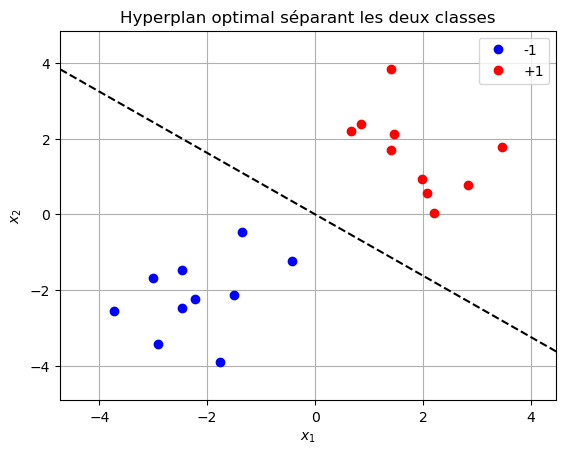

Taux d'erreurs : 0.0


In [45]:
SVMhardmarginclassical = SVMHardMarginClassical(points, labels)
SVMhardmarginclassical.run_and_plot()
SVMhardmarginclassical.compute_errors()
print(f"Taux d'erreurs : {SVMhardmarginclassical.errors.get('error rate')}")

Comme en témoigne la figure ci-dessous, avec le dataset généré, et l'yperplan optimal obtenu avec la SVM à marge rigide : $0.52x + 0.64y + 0.00 = 0$, nous obtenons un taux d'erreur de 0%.

Pour étoffer le propos, affichons les frontières de décision ainsi que les vecteurs supports par l'intermédiaire de la méthode `plot_results`.

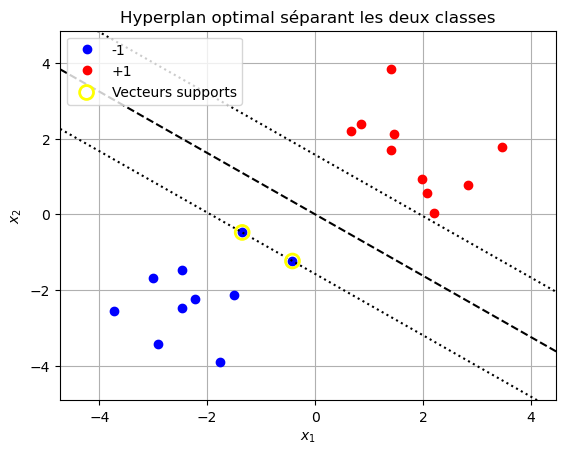

In [46]:
SVMhardmarginclassical.plot_results(plot_marge=True, plot_support_vectors=True)

# Question 3.
Modifier le label de 5 points afin de rendre ce dataset non linéairement séparable.

Cela se réalisera en trois temps :
1. **Sélection des Indices** : Nous utilisons `np.random.choice` pour sélectionner 5 indices aléatoires parmi les 20 points.
2. **Inversion des Labels** : Nous inversons les labels des points sélectionnés en multipliant par -1.
3. **Affichage et Visualisation** : Nous affichons les nouveaux labels et visualisons les points avec leurs nouveaux labels pour vérifier que le dataset est maintenant non linéairement séparable.

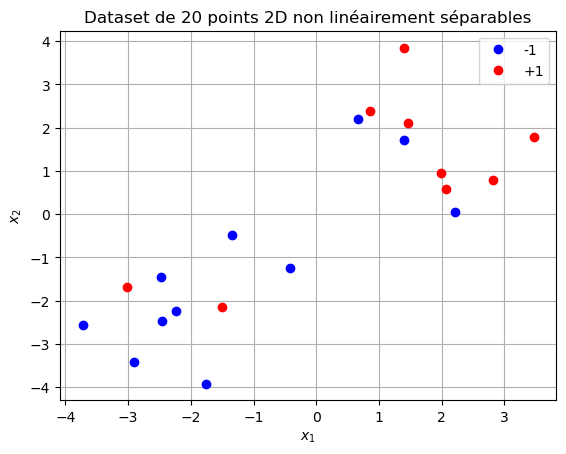

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Sélectionner 5 indices aléatoires
indices_to_flip = np.random.choice(20, 5, replace=False)

# Inverser les labels des points sélectionnés
labels[indices_to_flip] = -labels[indices_to_flip]

# Visualiser les points avec les nouveaux labels
# Afficher les points
plt.plot(
    points[:, 0][labels == -1], points[:, 1][labels == -1], "bo", label="-1"
)  # Cercles bleus pour -1
plt.plot(
    points[:, 0][labels == 1], points[:, 1][labels == 1], "ro", label="+1"
)  # Cercles rouges pour +1
plt.title("Dataset de 20 points 2D non linéairement séparables")
plt.xlabel(r"$x_{1}$")
plt.ylabel(r"$x_{2}$")
plt.grid()
plt.legend()
plt.show()

## Question 4.
Implémenter deux modèles vus en cours (selon les losses choisies : hinge, Ramp ou Hard margin) permettant d'obtenir les hyperplans optimaux. Donner les deux hyperplans obtenus.

### Formulation du problème d'optimisation de la SVM avec *Hinge Loss* et reformulation.

Nous cherchons cherche à résoudre le problème d'optimisation suivant :
$$
\begin{aligned}
& \underset{\mathbf{w} \in \mathbb{R}^{p}, b \in \mathbb{R}}{\text{minimiser}}
& & \frac{1}{2} \|\mathbf{w}\| + C \sum\limits_{i=1}^{n} \epsilon_{i} \\
& \text{sous les contraintes}
& & y_i (\mathbf{w}^T \mathbf{x}_i + b) \geq 1 - \epsilon_{i}, \quad \forall i \in \{1, \ldots, n\} \\
& & & \epsilon_{i} \geq 0, \quad \forall i \in \{1, \ldots, n\}
\end{aligned}
$$

Avec, pour rappel, $p = 3$ et $n = 20$ et $\|\mathbf{w}\| = \sum\limits_{j=1}^{p} |w_j|$ et $\epsilon_{i}$ l'erreur de $x_{i}$ si ce dernier est dans la marge :
$$
\epsilon_{i} = \left\{
\begin{array}{ll}
0 & \text{si } y_i (\mathbf{w}^T \mathbf{x}_i + b) \geq 1 \text{ ou } y_i (\mathbf{w}^T \mathbf{x}_i + b) \leq -1 \\
1 - y_i (\mathbf{w}^T \mathbf{x}_i + b) & \text{sinon}
\end{array}
\right.
$$

Si $y_i (\mathbf{w}^T \mathbf{x}_i + b) \leq -1$ alors on a une erreur de $2$ quelle que soit la valeur $y_i (\mathbf{w}^T \mathbf{x}_i + b)$

Dans un démarche analogue à celle réalisée dans le cadre de la reformulation de la SVM à marge rigide, nous pouvons reformuler le problème ci-dessus de la manière suivante (nous poserons de nouveau $b = w_3$):
$$
\begin{aligned}
& \underset{(\mathbf{w_0}, \mathbf{w_1}, \mathbf{w_2}) \in \mathbb{R}^{3}, \epsilon_{i} \in \mathbb{R}^{+}}{\text{minimiser}}
& & \frac{1}{2} | \mathbf{w}_{1} | + \frac{1}{2} | \mathbf{w}_{2} | + 0 | \mathbf{w}_{3} | + C \sum\limits_{i=1}^{n} \epsilon_{i}  \\
& \text{sous les contraintes}
& & y_i (w_{1} x_{1, i} + w_{2} x_{2, i} + w_{3}) \geq 1 - \epsilon_{i}, \quad \forall i \in \{1, \ldots, n\} \\
& & & \epsilon_{i} \geq 0, \quad \forall i \in \{1, \ldots, n\}
\end{aligned}
$$

En modifiant les contraintes et en reformulant le problème d'optimisation de la SVM avec Hinge Loss, nous obtenons :
$$
\begin{aligned}
& \underset{(\mathbf{w_0}, \mathbf{w_1}, \mathbf{w_2}) \in \mathbb{R}^{3}, \epsilon_{i} \in \mathbb{R}}{\text{minimiser}}
& & \frac{1}{2} | \mathbf{w}_{1} | + \frac{1}{2} | \mathbf{w}_{2} | + 0 | \mathbf{w}_{3} | + C \sum\limits_{i=1}^{n} \epsilon_{i}  \\
& \text{sous les contraintes}
& & -y_i (w_{1} x_{1, i} + w_{2} x_{2, i} + w_{3}) - \epsilon_{i} \leq - 1, \quad \forall i \in \{1, \ldots, n\} \\
& & & \epsilon_{i} \geq 0, \quad \forall i \in \{1, \ldots, n\}
\end{aligned}
$$

Nous cherchons à exprimer ce problème sous la forme canonique d'un problème d'optimisation linéaire :

$$
\begin{aligned}
& \underset{\mathbf{x}}{\text{minimiser}}
& & \mathbf{c}^{T} \mathbf{x} \\
& \text{sous les contraintes}
& & A \mathbf{x} \leq \mathbf{b}
\end{aligned}
$$

avec $\mathbf{x} = \begin{bmatrix} \mathbf{w} \\ \boldsymbol{\epsilon} \end{bmatrix}$, et les matrices définies comme suit :

$$
\mathbf{x} = \begin{bmatrix} w_{1} \\ w_{2} \\ w_{3} \\ \epsilon_1 \\ \epsilon_2 \\ \vdots \\ \epsilon_n \end{bmatrix}
$$
avec $\mathbf{x} \in \mathbb{R}^{n+3}$

$$
\mathbf{c} = \begin{bmatrix} \frac{1}{2} \\ \frac{1}{2} \\ 0 \\ C \\ C \\ \vdots \\ C \end{bmatrix}
$$
avec $\mathbf{c} \in \mathbb{R}^{n+3}$

$$
\mathbf{b} = \begin{bmatrix} -1 \\ -1 \\ \vdots \\ -1 \end{bmatrix}
$$
avec $\mathbf{b} \in \mathbb{R}^{n}$

$$
A = \begin{bmatrix}
-y_{1} x_{1,1} & -y_{1} x_{1,2} & -y_{1} & -1 & 0 & \dots & 0 \\
-y_{2} x_{2,1} & -y_{2} x_{2,2} & -y_{2} & 0 & -1 & \dots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
-y_{n} x_{n,1} & -y_{n} x_{n,2} & -y_{n} & 0 & 0 & \dots & -1
\end{bmatrix}
$$
avec $A \in \mathbb{R}^{n \times (n+3)}$

### Elements de précision relatifs à l'interprétation des $\epsilon_i$ dans le cadre de la SVM avec *Hinge Loss*

Les **variables slack** $\epsilon_i$ sont introduites pour gérer les erreurs de classification et permettre une **marge souple** (*soft margin*).
Si un point  $x_i$ est bien classé et hors de la marge** (*i.e.* $y_i (\mathbf{w}^T \mathbf{x}_i + b) \geq 1$), alors **$\epsilon_i = 0$** car aucune erreur n'est commise.
Si en revanche un point $x_i$ est mal classé ou à l'intérieur de la marge (*i.e.* $y_i (\mathbf{w}^T \mathbf{x}_i + b) < 1$), dans ce cas :
  - $\epsilon_i > 0$ indique de combien le point $x_i$ est du mauvais côté de la marge ;
  - Les valeurs des $\epsilon_i$ sont proportionnels à l'erreur commise ;
  - Si $\epsilon_i \geq 1$, alors le point est totalement mal classé ($i.e.$ il est du mauvais côté de l'hyperplan).

Sur la base de ce constat, nous allons sur-définir la méthode `compute_errors()` héritée de la classe `SVMBase` pour y intégrer les $\epsilon_{i}$.
Nous allons ainsi calculer la moyenne des $\epsilon_{i}$ : $\frac{1}{n} \sum\limits_{i=1}^{n} \epsilon_{i}$

### Elements relatifs à l'implémentation du modèle de la SVM avec *Hinge Loss*

Dans la continuité de l'implémentation de la classe `SVMHardMargin` nous allons créer une classe `SVMHingeLoss` qui hérite de la classe `SVMBase` et qui implémente les méthodes abstraites de cette dernière en vue de résoudre le problème d'optimisation de la SVM avec *Hinge Loss*.

Dans le code ci-dessous, pour une aisance de lecture dans la définition du modèle à minimiser, nous allons exploiter la fonction de `xsum` de la librairie `mip` de la manière suivante :
```python
model.objective = minimize(
    xsum(c[i] * w_vars[i] for i in range(3)) + C * xsum(epsilon_vars)
  )
```
C'est la raison pour laquelle nious pouvons définir $c$ sans la partie relative à $\boldsymbol{\epsilon}$ :
```python
c = [0.5, 0.5, 0]
```

Nous aurions pu tout à fait définir la fonction objective ainsi :
```python
model.objective = minimize(
    xsum(c[i] * x_vars[i] for i in range(n+3))
  )
```
avec :
```python
x_vars = w_vars + epsilon_vars
```
Mais dans ce cas de figure $\mathbf{c}$ aurait du s'exprimer ainsi :
```python
c = [0.5, 0.5, 0] + [C for _ in range(n)]
```

In [ ]:
class SVMHingeLoss(SVMBase):
    """
    Implémentation du SVM avec Hinge Loss (marge souple).
    """

    def __init__(self, points, labels, C=1):
        """
        Initialise le SVM avec Hinge Loss.
        """
        super().__init__(points, labels)
        self.C = C

    def set_model(self):
        """
        Crée le modèle MIP pour le SVM avec Hinge Loss.
        """
        m = self.n + 3
        c = [0.5, 0.5, 0] + [
            self.C for _ in range(self.n)
        ]  # Vecteur des coûts
        b = [-1 for _ in range(self.n)]  # Vecteur des contraintes

        # Matrice des contraintes
        A = []
        for i in range(self.n):
            l = [
                -self.labels[i] * self.points[i][0],
                -self.labels[i] * self.points[i][1],
                -self.labels[i],
            ]
            l += [-1 if j == i else 0 for j in range(self.n)]
            A.append(l)

        # Création du modèle
        self.model = Model()

        # Création des variables
        w_vars = [
            self.model.add_var(var_type=CONTINUOUS, lb=0) for _ in range(3)
        ]
        epsilon_vars = [
            self.model.add_var(var_type=CONTINUOUS, lb=0)
            for _ in range(self.n)
        ]
        x_vars = w_vars + epsilon_vars

        # Ajout de la fonction objectif
        self.model.objective = minimize(
            xsum(c[i] * w_vars[i] for i in range(3))
            + self.C * xsum(epsilon_vars)
        )

        # Ajout des contraintes
        for i in range(self.n):
            self.model += xsum(A[i][j] * x_vars[j] for j in range(m)) <= b[i]
            self.model += x_vars[i + 3] >= 0

    def solve(self, verbose=False):
        """
        Résout le modèle MIP.
        """
        super().solve(verbose)
        self.epsilons = [v.x for v in self.model.vars[3 : self.n + 3]]

    def compute_errors(self):
        super().compute_errors()
        epsilons = {}
        if self.epsilons is not None:
            epsilons = {
            "Erreur moyenne slack" : np.mean(self.epsilons)
					}
        self.errors.update(epsilons)

    @classmethod
    def train_multiple_models(cls, points, labels, C_values):
        """
        Entraîne plusieurs modèles SVM avec différentes valeurs de C et retourne leurs résultats.

        :param points: Données d'entrée.
        :param labels: Étiquettes associées.
        :param C_values: Liste des valeurs de C à tester.
        :return: Liste des modèles entraînés et liste des erreurs associées.
        """
        trained_models = []
        errors = []

        for C in C_values:
            current_svm = cls(points, labels, C)
            current_svm.train_model()
            current_svm.compute_errors()
            trained_models.append(current_svm)
            errors.append(current_svm.errors)

        return (
            trained_models,
            errors,
        )  # On retourne les modèles et leurs erreurs

    @classmethod
    def plot_C_variation(cls, trained_models, C_values, colors, plot_marge=False, plot_support_vectors=False):
        """
        Trace les hyperplans pour les modèles entraînés avec différentes valeurs de C.

        :param trained_models: Liste des modèles entraînés (résultats de train_multiple_models).
        :param C_values: Liste des valeurs de C utilisées.
        """

        if colors and len(colors) != len(C_values):
            print("Le nombre de couleurs doit correspondre au nombre de valeurs de C.")
            return
        # Générer automatiquement une liste de couleurs si aucune n'est fournie
        if not colors:
            colors = [cm.viridis(i / len(C_values)) for i in range(len(C_values))]

        # Tracer les points
        plt.figure(figsize=(10, 6))
        plt.scatter(
            trained_models[0].points[:, 0],
            trained_models[0].points[:, 1],
            c=trained_models[0].labels,
            cmap="bwr",
            edgecolors="k",
        )

        # Tracer les hyperplans et marges
        x_min, x_max = (
            trained_models[0].points[:, 0].min() - 1,
            trained_models[0].points[:, 0].max() + 1,
        )
        y_min, y_max = (
            trained_models[0].points[:, 1].min() - 1,
            trained_models[0].points[:, 1].max() + 1,
        )
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500)
        )

        # Liste pour stocker les handles des légendes
        legend_handles = []

        for i, model in enumerate(trained_models):
            if model.w:
                w = model.w
                C_value = C_values[i]
                equation_str = rf"$\text{{C =}} {C_value} \text{{ Equation de l'hyperplan: }} {model.w[0]:.2f}x_1 + {model.w[1]:.2f}x_2 + {model.w[2]:.2f} = 0$"
                display(Math(equation_str))
                Z = w[0] * xx + w[1] * yy + w[2]

                # Tracer l'hyperplan
                plt.contour(
                    xx,
                    yy,
                    Z,
                    levels=[0],
                    colors=[colors[i]],
                    linestyles="dashed",
                )
                if plot_marge:
                    # Tracer les marges (+1 et -1)
                    plt.contour(
                      xx,
                      yy,
                      Z,
                      levels=sorted([-1, 1]),
                      colors=[colors[i]],
                      linestyles="dotted",
                  )

                # Ajouter une légende en traçant un point invisible
                legend_handles.append(
                    plt.plot(
                        [],
                        [],
                        color=colors[i],
                        linestyle="dashed",
                        label=f"C={C_values[i]}",
                    )[0]
                )
                if plot_support_vectors:
                    support_vectors = model.detect_vectors()
                    support_vectors = [v.get("index") for v in support_vectors]
                    plt.scatter(
                        model.points[support_vectors, 0],
                        model.points[support_vectors, 1],
                        s=100,
                        facecolors="none",
                        edgecolors=colors[i],
                        linewidths=2,
                        label=f"Vecteurs supports C = {C_values[i]}",
                        zorder=3,  # S'assure que les points sont bien affichés au premier plan
                    )

        # Ajout de la légende et affichage du graphe
        plt.title(
            "Effet de C sur l'hyperplan optimal et la taille de la marge"
        )
        plt.xlabel(r"$x_{1}$")
        plt.ylabel(r"$x_{2}$")
        plt.legend(handles=legend_handles, loc="best")
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_svm_errors(self, C_values, errors, plot_taux_erreurs=True, plot_mean_slack=True):
        """
        Trace le graphique de l'impact de C sur les erreurs du SVM.

        :param C_values: Liste des valeurs de C (hyperparamètre SVM)
        :param errors: Liste des dictionnaires contenant les erreurs pour chaque C
        """

        # Vérification des entrées
        if len(C_values) != len(errors):
            raise ValueError(
                "La longueur de C_values et errors doit être identique."
            )

        # Extraire les valeurs des erreurs
        taux_erreurs = [err["error rate"] for err in errors]
        mean_slack = [err["Erreur moyenne slack"] for err in errors]

        # Tracer le graphique
        plt.figure(figsize=(10, 6))
        if plot_mean_slack:
            plt.plot(
                C_values,
                mean_slack,
                marker="o",
                linestyle="-",
                label="Erreur moyenne slack",
                color="red",
            )
        if plot_taux_erreurs :
            plt.plot(
                C_values,
                taux_erreurs,
                marker="s",
                linestyle="--",
                label="Taux d'erreurs",
                color="blue",
            )

        # Utilisation d'une échelle logarithmique pour C
        plt.xscale("log")
        plt.xlabel("Valeur de C (échelle logarithmique)")
        plt.ylabel("Erreur")
        plt.title("Impact de C sur les erreurs du SVM")
        plt.legend()
        plt.grid(True)
        plt.show()

<IPython.core.display.Math object>

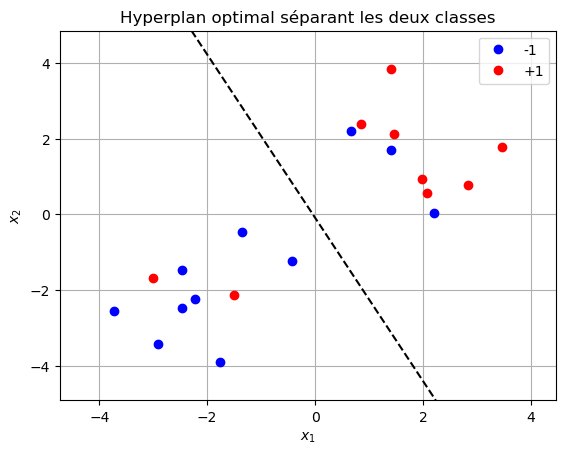

Taux d'erreurs : 25.0


In [49]:
SVMhingeloss = SVMHingeLoss(points, labels, 0.1)
SVMhingeloss.run_and_plot()
SVMhingeloss.compute_errors()
print(f"Taux d'erreurs : {SVMhingeloss.errors.get('error rate')}")

Comme en témoigne la figure ci-dessous, avec le dataset généré, et l'yperplan optimal obtenu avec la SVM avec *Hine Loss* : $0.31x + 0.14y + 0.01 = 0$, nous obtenons un taux d'erreur de 25%.

Dans une démarche analogue à celle réalisée précédemment, étoffons le propos en affichant les frontières de décision ainsi que les vecteurs supports par l'intermédiaire de la méthode `plot_results`.

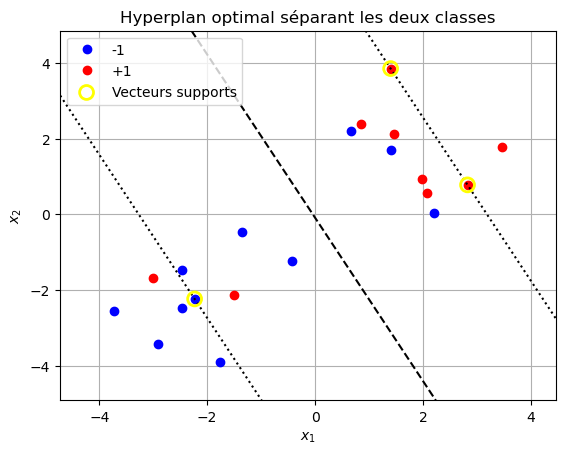

In [50]:
SVMhingeloss.plot_results(plot_marge=True, plot_support_vectors=True)

Analysons maintenant l'effet de $C$ sur le plan optimal.

### Analyse quantitative de l'effet de $C$ sur le plan optimal

Nous allons étudier l'impact de la variation de la pondération $C$ utilisée dans les losses sur le plan optimal. Pour ce faire, nous allons itérer sur les valeurs de $C$ suivantes : $[0.1, 0.3, 1, 10]$, chacune représentée par une couleur différente sur le graphique.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

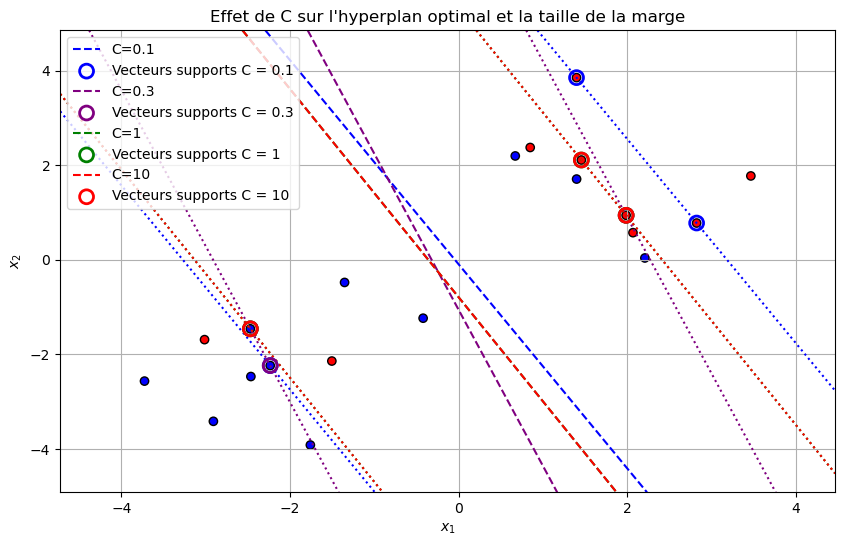

In [51]:
C_values = [0.1, 0.3, 1, 10]
colors = ["blue", "purple", "green", "red"]
trained_models, errors = SVMhingeloss.train_multiple_models(
    points, labels, C_values
)
SVMhingeloss.plot_C_variation(trained_models, C_values, colors, plot_marge=True, plot_support_vectors=True)

L'hyperparamètre $C$ dans la SVM avec *Hinge Loss* contrôle le compromis entre maximisation de la marge et minimisation des erreurs de classification.
- $C$ faible (par exemple $C = 0.1$) :
	- La SVM maximise la marge entre les classes ;
	- Elle tolère davantage d'erreurs sur le jeu d'entraînement ;
	- Cela entraîne une frontière plus large mais peut conduire à un modèle moins précis sur l'entraînement. **Cependant elle assure une meilleure généralisation sur le jeu de test.**
- $C$ élevé (par exemple $C = 10$) :
	- La SVM pénalise fortement les erreurs et essaie de les minimiser ;
	- Cela conduit à une frontière plus stricte ;
	- Cependant, cela peut mener à un sur-ajustement, où le modèle suit trop fidèlement les données d'entraînement et pourrait mal généraliser à de nouvelles données (i.e. **sur-apprentissage**).

Comme en témoigne la figure ci-dessus, les marges se rétrécissent lorsque $C$ augmente. En effet, les frontières de décision relatives à la valeur de $C = 10$ (en rouge) est plus étroite que celle à $C = 0.1$ qui est plus large (en bleu).

Pour étayer ce constat, nous allons calculer le taux d'erreur en fonction de $C$ pour la SVM avec *Hinge Loss*.

### Affichage du taux d'erreur en fonction de $C$ pour la SVM avec *Hinge Loss*

Etant donné qu'avec le jeu de données dont nous disposons, les éléments relatifs au taux d'erreurs ainsi qu'au nombre d'erreurs sont les mêmes indépendamment de la valeur de $C$, nous allons exploiter l'erreur quadratique moyenne des $\epsilon_{i}$ (défini préalablement).

Pour ce faire, nous allons implémenter une méthode `plot_svm_errors()` qui prendra en paramètre les valeurs de $C$ et les erreurs associées, puis affichera le graphique correspondant.

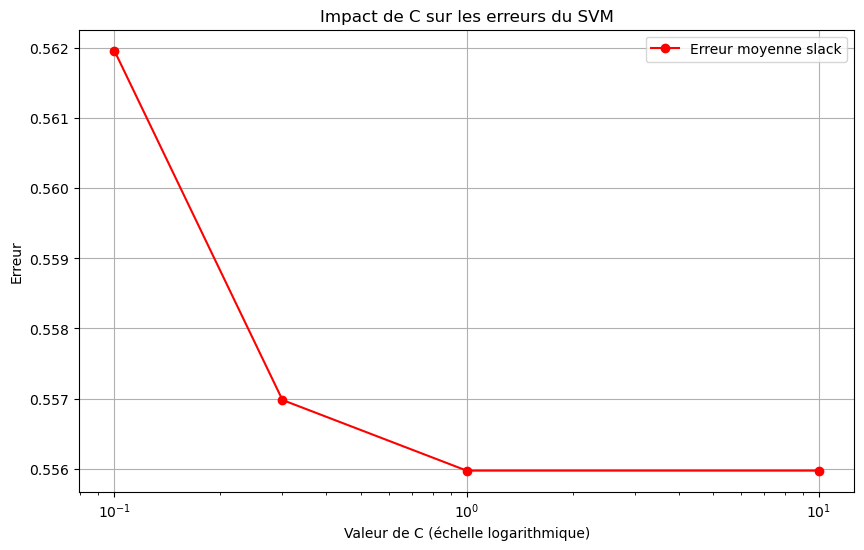

In [52]:
SVMhingeloss.plot_svm_errors(C_values, errors, plot_taux_erreurs=False, plot_mean_slack=True)

Les résultats présentés dans le graphique ci-dessus sont en adéquation avec le constat réalisé précédemment dans l'analyse quantitative de l'effet de $C$ sur le plan optimal : plus $C$ est élevé, moins les erreurs sont tolérées.

### Formulation du problème d'optimisation de la SVM avec Ramp Loss et reformulation.

Nous cherchons cherche à résoudre le problème d'optimisation suivant :
$$
\begin{aligned}
& \underset{\mathbf{w} \in \mathbb{R}^{p}, b \in \mathbb{R}}{\text{minimiser}}
& & \frac{1}{2} \|\mathbf{w}\| + C \left( \sum\limits_{i=1}^{n} \epsilon_{i} + 2 \sum\limits_{i=1}^{n} z_{i} \right) \\
& \text{sous les contraintes}
& & y_i (\mathbf{w}^T \mathbf{x}_i + b) \geq 1 - \epsilon_{i} - M z_{i}, \quad \forall i \in \{1, \ldots, n\} \\
& & & 0 \leq \epsilon_{i} \leq 2, \quad \forall i \in \{1, \ldots, n\} \\
& & & z_{i} \in \{0, 1\}, \quad \forall i \in \{1, \ldots, n\}
\end{aligned}
$$

avec $M$ une constante suffisamment grande pour que $z_{i}$ soit égal à $1$ si et seulement si $\epsilon_{i} > 1$ et $C$ le poids de la minimisation de l'erreur par rapport à la marge.

La différence avec la *Hinge Loss* est l'introduction d'une variable binaire $z_{i}$ pour tout $i \in \{1, \ldots, n\}$ qui vaut :
$$
z{i} = \left\{
\begin{array}{ll}
1 & \text{si } y_i (\mathbf{w}^T \mathbf{x}_i + b) \leq -1 \\
0 & \text{sinon}
\end{array}
\right.
$$

Dans la continuité des travaux réalisés jusqu'à présente, nous pouvons reformuler le problème ci-dessus de la manière suivante (nous poserons de nouveau $b = w_3$):
$$
\begin{aligned}
& \underset{(\mathbf{w_0}, \mathbf{w_1}, \mathbf{w_2}) \in \mathbb{R}^{3}, \epsilon_{i} \in \mathbb{R}^{+}}{\text{minimiser}}
& & \frac{1}{2} | \mathbf{w}_{1} | + \frac{1}{2} | \mathbf{w}_{2} | + 0 | \mathbf{w}_{3} | + C \left( \sum\limits_{i=1}^{n} \epsilon_{i} + 2 \sum\limits_{i=1}^{n} z_{i} \right) \\
& \text{sous les contraintes}
& & y_i (w_{1} x_{1, i} + w_{2} x_{2, i} + w_{3}) \geq 1 - \epsilon_{i} - M z_{i}, \quad \forall i \in \{1, \ldots, n\} \\
& & & 0 \leq \epsilon_{i} \leq 2, \quad \forall i \in \{1, \ldots, n\} \\
& & & z_{i} \in \{0, 1\}, \quad \forall i \in \{1, \ldots, n\}
\end{aligned}
$$

En modifiant les contraintes et en reformulant le problème d'optimisation de la SVM avec Hinge Loss, nous obtenons :
$$
\begin{aligned}
& \underset{(\mathbf{w_0}, \mathbf{w_1}, \mathbf{w_2}) \in \mathbb{R}^{3}, \epsilon_{i} \in \mathbb{R}^{+}}{\text{minimiser}}
& & \frac{1}{2} | \mathbf{w}_{1} | + \frac{1}{2} | \mathbf{w}_{2} | + 0 | \mathbf{w}_{3} | + C \left( \sum\limits_{i=1}^{n} \epsilon_{i} + 2 \sum\limits_{i=1}^{n} z_{i} \right) \\
& \text{sous les contraintes}
& & -y_i (w_{1} x_{1, i} + w_{2} x_{2, i} + w_{3}) - \epsilon_{i} - M z_{i} \leq - 1, \quad \forall i \in \{1, \ldots, n\} \\
& & & 0 \leq \epsilon_{i} \leq 2, \quad \forall i \in \{1, \ldots, n\} \\
& & & z_{i} \in \{0, 1\}, \quad \forall i \in \{1, \ldots, n\}
\end{aligned}
$$

Nous cherchons à exprimer ce problème sous la forme canonique d'un problème d'optimisation linéaire :

$$
\begin{aligned}
& \underset{\mathbf{x}}{\text{minimiser}}
& & \mathbf{c}^{T} \mathbf{x} \\
& \text{sous les contraintes}
& & A \mathbf{x} \leq \mathbf{b}
\end{aligned}
$$

avec $\mathbf{x} = \begin{bmatrix} \mathbf{w} \\ \boldsymbol{\epsilon} \\ \boldsymbol{z} \end{bmatrix}$, et les matrices définies comme suit :

$$
\mathbf{x} = \begin{bmatrix} w_{1} \\ w_{2} \\ w_{3} \\ \epsilon_1 \\ \epsilon_2 \\ \vdots \\ \epsilon_n \\ z_{1} \\ z_{2} \\ \vdots \\ z_{n} \end{bmatrix}
$$
avec $\mathbf{x} \in \mathbb{R}^{2n+3}$

$$
\mathbf{c} = \begin{bmatrix} \frac{1}{2} \\ \frac{1}{2} \\ 0 \\ C \\ C \\ \vdots \\ C \\ 2C \\ 2C \\ \vdots \\ 2C \end{bmatrix}
$$
avec $\mathbf{c} \in \mathbb{R}^{2n+3}$

$$
\mathbf{b} = \begin{bmatrix} -1 \\ -1 \\ \vdots \\ -1 \end{bmatrix}
$$
avec $\mathbf{b} \in \mathbb{R}^{n}$

$$
A = \begin{bmatrix}
-y_{1} x_{1,1} & -y_{1} x_{1,2} & -y_{1} & -1 & 0 & \dots & 0 & -M & 0 & \dots & 0 \\
-y_{2} x_{2,1} & -y_{2} x_{2,2} & -y_{2} & 0 & -1 & \dots & 0 & 0 & -M & \dots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots & \ddots \\
-y_{n} x_{n,1} & -y_{n} x_{n,2} & -y_{n} & 0 & 0 & \dots & -1 & 0 & 0 & \dots & -M \\
\end{bmatrix}
$$
avec $A \in \mathbb{R}^{n \times (2n+3)}$

**Ajout de la contrainte $z_{i}$**:
D'après la définition de $z_{i}$, donnée ci-dessus, la variable $z_{i}$ doit s'activer uniquement quand un point est fortement mal classé, c'est-à-dire quand il est au moins à distance $-1$ du bon côté de la séparation.
Cette contrainte peut se traduire ainsi :
$$
y_i (w_{1} x_{1, i} + w_{2} x_{2, i} + w_{3}) + M z_{i} \geq -1
$$
En effet, si $z_{i} = 0$ (*i.e.* le point est bien classé ou dans la marge), nous obtenons :
$$
y_i (w_{1} x_{1, i} + w_{2} x_{2, i} + w_{3}) \geq -1
$$
Ce qui signifie que le point peut être correctement classé ou dans la marge mais pas trop loin.
En revanche, si $z_{i} = 1$ (*i.e.* le point est mal classé ou dans la marge), l'inéquation devient :
$$
y_i (w_{1} x_{1, i} + w_{2} x_{2, i} + w_{3}) + M \geq -1
$$
Comme $M$ est pris suffisament grand, comme par exemple 1000, cette contrainte est toujours vérifiée quelle que soit la valeur de $y_{i} (w_{1} x_{1, i} + w_{2} x_{2, i} + w_{3})$.
Tous ces éléments indiquent que $M$ relâche la contrainte quand $z_{i} = 1$ pour que l'optimisation puisse "accepter" les erreurs sévères. Et $z_{i}$ est forcé à $1$ si et seulement si $y_{i} (w_{1} x_{1, i} + w_{2} x_{2, i} + w_{3}) \leq -1$.

Dans le cadre de l'implémentation, cette contrainte se caractérise ainsi :
```python
model += (
        y[i] * (w_vars[0] * x[i][0] + w_vars[1] * x[i][1] + w_vars[2])
        + M * z_vars[i]
        >= -1
    )
```

In [ ]:
class SVMRampLoss(SVMBase):
    """
    Implémentation du SVM avec Ramp Loss.
    """

    def __init__(self, points, labels, C=1, M=1000):
        """
        Initialise le SVM avec Hinge Loss.
        """
        super().__init__(points, labels)
        self.C = C
        self.M = M

    def set_model(self):
        """
        Crée le modèle MIP pour le SVM avec Hinge Loss.
        """
        x = self.points
        y = self.labels
        m = 2 * self.n + 3  # Nombre total de variables
        c = [0.5, 0.5, 0] + [self.C for _ in range(self.n)] + [2 * self.C for _ in range(self.n)] # Vecteur des coûts
        b = [-1 for _ in range(self.n)] # Vecteur des contraintes
        A = [] # Matrice des contraintes
        for i in range(self.n):
            l = [-y[i] * x[i][0], -y[i] * x[i][1], -y[i]]  # w1, w2, w3
            l += [-1 if j == i else 0 for j in range(self.n)]  # epsilon_i
            l += [-self.M if j == i else 0 for j in range(self.n)]  # z_i
            A.append(l)
        # création du modèle
        self.model = Model()
        # variables continues : w1, w2, w3, ε_i
        w_vars = [self.model.add_var(var_type=CONTINUOUS, lb=0) for _ in range(3)]
        epsilon_vars = [
            self.model.add_var(var_type=CONTINUOUS, lb=0) for _ in range(self.n)
        ]
        # variables binaires : z_i
        z_vars = [self.model.add_var(var_type=BINARY) for _ in range(self.n)]
        # variables x qui concatène w, ε et z
        x_vars = w_vars + epsilon_vars + z_vars
        # ajout de la fonction objectif
        # séparation des w_vars, epsilons_vars et z_vars pour une meilleure lisibilité
        self.model.objective = minimize(
            xsum(c[i] * w_vars[i] for i in range(3))
            + self.C * xsum(epsilon_vars)
            + 2 * self.C * xsum(z_vars)
        )
        # Ajout des contraintes
        for i in range(self.n):
            self.model += xsum(A[i][j] * x_vars[j] for j in range(m)) <= b[i]
            # 0 <= $\epsilon_i$ <= 2
            # (le décalage de 3 provient de la présence des variables w_1, w_2 et w_3)
            self.model += x_vars[i + 3] >= 0
            self.model += x_vars[i + 3] <= 2
            # contraintes sur z_i
            self.model += (
                y[i] * (w_vars[0] * x[i][0] + w_vars[1] * x[i][1] + w_vars[2])
                + self.M * z_vars[i]
                >= -1
            )
            # Ajout explicite que z_i est binaire (déjà garanti par BINARY mais assure
            # une meilleure lisibilité)
            self.model += z_vars[i] >= 0
            self.model += z_vars[i] <= 1

    def solve(self, verbose=False):
        """
        Résout le modèle MIP.
        """
        super().solve(verbose)
        self.epsilons = [v.x for v in self.model.vars[3 : self.n + 3]]
        self.z = [v.x for v in self.model.vars[self.n + 3:]]

    def compute_errors(self):
        super().compute_errors()
        epsilons = {}
        if self.epsilons is not None:
            epsilons = {"Erreur moyenne slack": np.mean(self.epsilons)}
        self.errors.update(epsilons)

    @classmethod
    def train_multiple_models(cls, points, labels, C_values):
        """
        Entraîne plusieurs modèles SVM avec différentes valeurs de C et retourne leurs résultats.

        :param points: Données d'entrée.
        :param labels: Étiquettes associées.
        :param C_values: Liste des valeurs de C à tester.
        :return: Liste des modèles entraînés et liste des erreurs associées.
        """
        trained_models = []
        errors = []

        for C in C_values:
            current_svm = cls(points, labels, C)
            current_svm.train_model()
            current_svm.compute_errors()
            trained_models.append(current_svm)
            errors.append(current_svm.errors)

        return (
            trained_models,
            errors,
        )  # On retourne les modèles et leurs erreurs

    @classmethod
    def plot_C_variation(cls, trained_models, C_values, colors, plot_marge=False, plot_support_vectors=False):
        """
        Trace les hyperplans pour les modèles entraînés avec différentes valeurs de C.

        :param trained_models: Liste des modèles entraînés (résultats de train_multiple_models).
        :param C_values: Liste des valeurs de C utilisées.
        """

        if colors and len(colors) != len(C_values):
            print(
                "Le nombre de couleurs doit correspondre au nombre de valeurs de C."
            )
            return
        # Générer automatiquement une liste de couleurs si aucune n'est fournie
        if not colors:
            colors = [
                cm.viridis(i / len(C_values)) for i in range(len(C_values))
            ]

        # Tracer les points
        plt.figure(figsize=(10, 6))
        plt.scatter(
            trained_models[0].points[:, 0],
            trained_models[0].points[:, 1],
            c=trained_models[0].labels,
            cmap="bwr",
            edgecolors="k",
        )

        # Tracer les hyperplans et marges
        x_min, x_max = (
            trained_models[0].points[:, 0].min() - 1,
            trained_models[0].points[:, 0].max() + 1,
        )
        y_min, y_max = (
            trained_models[0].points[:, 1].min() - 1,
            trained_models[0].points[:, 1].max() + 1,
        )
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500)
        )

        # Liste pour stocker les handles des légendes
        legend_handles = []

        for i, model in enumerate(trained_models):
            if model.w:
                w = model.w
                C_value = C_values[i]
                equation_str = rf"$\text{{C =}} {C_value} \text{{ Equation de l'hyperplan: }} {model.w[0]:.2f}x_1 + {model.w[1]:.2f}x_2 + {model.w[2]:.2f} = 0$"
                display(Math(equation_str))
                Z = w[0] * xx + w[1] * yy + w[2]

                # Tracer l'hyperplan
                plt.contour(
                    xx,
                    yy,
                    Z,
                    levels=[0],
                    colors=[colors[i]],
                    linestyles="dashed",
                )

                if plot_marge:
                    # Tracer les marges (+1 et -1)
                    plt.contour(
                        xx,
                        yy,
                        Z,
                        levels=sorted([-1, 1]),
                        colors=[colors[i]],
                        linestyles="dotted",
                    )

                # Ajouter une légende en traçant un point invisible
                legend_handles.append(
                    plt.plot(
                        [],
                        [],
                        color=colors[i],
                        linestyle="dashed",
                        label=f"C={C_values[i]}",
                    )[0]
                )
                if plot_support_vectors:
                    support_vectors = model.detect_vectors()
                    support_vectors = [v.get("index") for v in support_vectors]
                    plt.scatter(
                        model.points[support_vectors, 0],
                        model.points[support_vectors, 1],
                        s=100,
                        facecolors="none",
                        edgecolors=colors[i],
                        linewidths=2,
                        label=f"Vecteurs supports C = {C_values[i]}",
                        zorder=3,  # S'assure que les points sont bien affichés au premier plan
                    )

                # Ajouter une légende en traçant un point invisible
                legend_handles.append(
                    plt.plot(
                        [],
                        [],
                        color=colors[i],
                        linestyle="dashed",
                        label=f"C={C_values[i]}",
                    )[0]
                )

        # Ajout de la légende et affichage du graphe
        plt.title(
            "Effet de C sur l'hyperplan optimal et la taille de la marge"
        )
        plt.xlabel(r"$x_{1}$")
        plt.ylabel(r"$x_{2}$")
        plt.legend(handles=legend_handles, loc="best")
        plt.grid(True)
        plt.legend()
        plt.show()

    @staticmethod
    def plot_svm_errors(
      C_values, errors, plot_taux_erreurs=True, plot_mean_slack=True
    ):
        """
        Trace le graphique de l'impact de C sur les erreurs du SVM.

        :param C_values: Liste des valeurs de C (hyperparamètre SVM)
        :param errors: Liste des dictionnaires contenant les erreurs pour chaque C
        """

        # Vérification des entrées
        if len(C_values) != len(errors):
            raise ValueError(
                "La longueur de C_values et errors doit être identique."
            )

        # Extraire les valeurs des erreurs
        taux_erreurs = [err["error rate"] for err in errors]
        mean_slack = [err["Erreur moyenne slack"] for err in errors]

        # Tracer le graphique
        plt.figure(figsize=(10, 6))
        if plot_mean_slack:
            plt.plot(
                C_values,
                mean_slack,
                marker="o",
                linestyle="-",
                label="Erreur moyenne slack",
                color="red",
            )
        if plot_taux_erreurs:
            plt.plot(
                C_values,
                taux_erreurs,
                marker="s",
                linestyle="--",
                label="Taux d'erreurs",
                color="blue",
            )

        # Utilisation d'une échelle logarithmique pour C
        plt.xscale("log")
        plt.xlabel("Valeur de C (échelle logarithmique)")
        plt.ylabel("Erreur")
        plt.title("Impact de C sur les erreurs du SVM")
        plt.legend()
        plt.grid(True)
        plt.show()

<IPython.core.display.Math object>

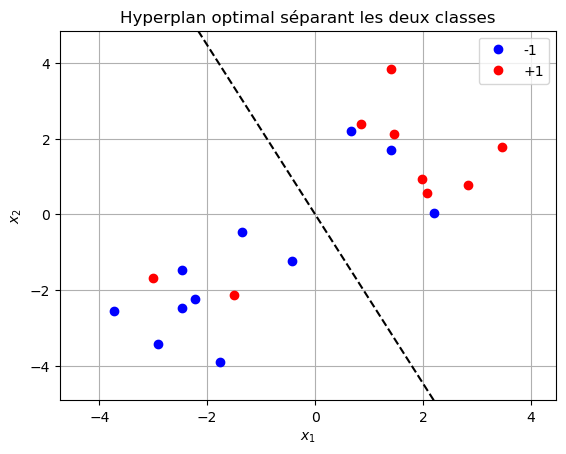

In [54]:
SVMramploss = SVMRampLoss(points, labels, 0.1, 1000)
SVMramploss.run_and_plot()

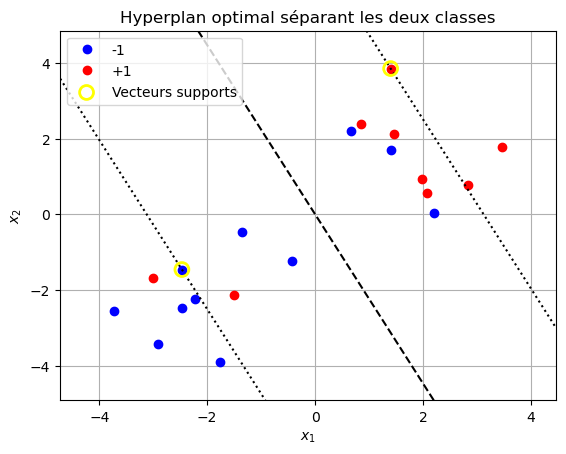

In [55]:
SVMramploss.plot_results(plot_marge=True, plot_support_vectors=True)

### Analyse quantitative de l'effet de $C$ sur le plan optimal dans le cadre de la SVM avec *Ramp Loss*

Nous allons réaliser la démarche analogue à celle réalisée dans le cadre de l'analyse quantitative de l'effet de $C$ sur le plan optimal dans le cadre de la SVM avec *Hinge Loss*.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

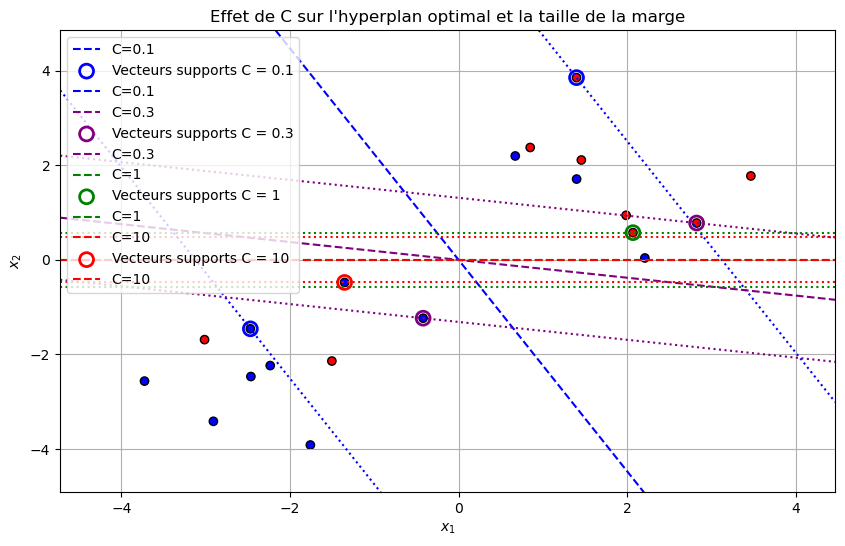

In [56]:
C_values = [0.1, 0.3, 1, 10]
colors = ["blue", "purple", "green", "red"]
trained_models, errors = SVMRampLoss.train_multiple_models(
    points, labels, C_values
)
SVMRampLoss.plot_C_variation(trained_models, C_values, colors, plot_marge=True, plot_support_vectors=True)

Le constat est analogue à celui réalisé dans le cadre de la SVM avec *Hine Loss* : plus la valeur de $C$ est élévée plus la frontière de décision est stricte et moins les erreurs sont tolérées. En effet, la marges de décision associée à la valeur de $C = 0.1$ en bleue est plus large que celle associée à la valeur de $C = 10$ en rouge.

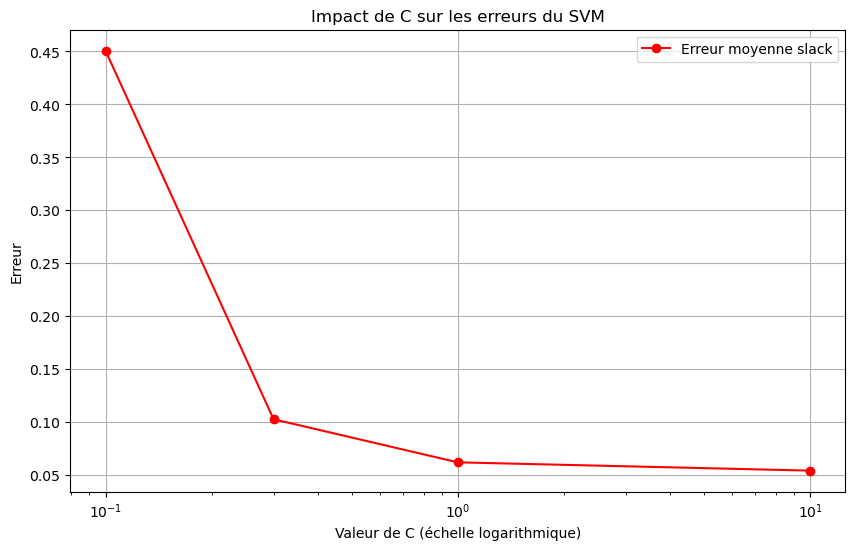

In [57]:
SVMRampLoss.plot_svm_errors(
    C_values=C_values, errors=errors, plot_taux_erreurs=False, plot_mean_slack=True
)

Le constat est également similaire à celui réalisé dans le cadre de la SVM avec *Hinge Loss* : plus $C$ est élevé, moins les erreurs sont tolérées.

### Formulation du problème d'optimisation de la SVM avec *Hard Margin Loss* et reformulation.

Nous cherchons cherche à résoudre le problème d'optimisation suivant :
$$
\begin{aligned}
& \underset{\mathbf{w} \in \mathbb{R}^{p}, b \in \mathbb{R}}{\text{minimiser}}
& & \frac{1}{2} \|\mathbf{w}\| + C \left(2 \sum\limits_{i=1}^{n} z_{i} \right) \\
& \text{sous les contraintes}
& & y_i (\mathbf{w}^T \mathbf{x}_i + b) \geq 1 - M z_{i}, \quad \forall i \in \{1, \ldots, n\} \\
& & & z_{i} \in \{0, 1\}, \quad \forall i \in \{1, \ldots, n\}
\end{aligned}
$$

En s'appuyant sur la travail réalisé précédemment il est aisé reformuler le problème d'optimisation de la SVM avec *Hard Margin Loss* :
$$
\begin{aligned}
& \underset{(\mathbf{w_0}, \mathbf{w_1}, \mathbf{w_2}) \in \mathbb{R}^{3}, \epsilon_{i} \in \mathbb{R}^{+}}{\text{minimiser}}
& & \frac{1}{2} | \mathbf{w}_{1} | + \frac{1}{2} | \mathbf{w}_{2} | + 0 | \mathbf{w}_{3} | + C \left(2 \sum\limits_{i=1}^{n} z_{i} \right) \\
& \text{sous les contraintes}
& & -y_i (w_{1} x_{1, i} + w_{2} x_{2, i} + w_{3}) - M z_{i} \leq - 1, \quad \forall i \in \{1, \ldots, n\} \\
& & & z_{i} \in \{0, 1\}, \quad \forall i \in \{1, \ldots, n\}
\end{aligned}
$$

Dans la continuité de nos raisonnements précédents, nous cherchons à exprimer ce problème sous la forme canonique d'un problème d'optimisation linéaire :

$$
\begin{aligned}
& \underset{\mathbf{x}}{\text{minimiser}}
& & \mathbf{c}^{T} \mathbf{x} \\
& \text{sous les contraintes}
& & A \mathbf{x} \leq \mathbf{b}
\end{aligned}
$$

avec $\mathbf{x} = \begin{bmatrix} \mathbf{w} \\ \boldsymbol{z} \end{bmatrix}$, et les matrices définies comme suit :

$$
\mathbf{x} = \begin{bmatrix} w_{1} \\ w_{2} \\ w_{3} \\ z_{1} \\ z_{2} \\ \vdots \\ z_{n} \end{bmatrix}
$$
avec $\mathbf{x} \in \mathbb{R}^{n+3}$

$$
\mathbf{c} = \begin{bmatrix} \frac{1}{2} \\ \frac{1}{2} \\ 0 \\ 2C \\ 2C \\ \vdots \\ 2C \end{bmatrix}
$$
avec $\mathbf{c} \in \mathbb{R}^{n+3}$

$$
\mathbf{b} = \begin{bmatrix} -1 \\ -1 \\ \vdots \\ -1 \end{bmatrix}
$$
avec $\mathbf{b} \in \mathbb{R}^{n}$

$$
A = \begin{bmatrix}
-y_{1} x_{1,1} & -y_{1} x_{1,2} & -y_{1} & -M & 0 & \dots & 0 \\
-y_{2} x_{2,1} & -y_{2} x_{2,2} & -y_{2} & 0 & -M & \dots & 0 \\
\vdots & \vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
-y_{n} x_{n,1} & -y_{n} x_{n,2} & -y_{n} & 0 & 0 & \dots & -M \\
\end{bmatrix}
$$
avec $A \in \mathbb{R}^{n \times (n+3)}$

### Lien entre la formulation du problème de SVM à marge rigide classique et celle avec *Hard Margin Loss*

Pour rappel, les formulations respectives des problèmes d'optimisation de la SVM à marge rigide et de la SVM avec *Hard Margin Loss* sont les suivantes :
1. SVM à marge rigide classique :
  - L'objectif est de minimiser $\frac{1}{2} \Vert w \Vert_{1}$ sous la contrainte stricte que tous les points soient classés correctement et à l'extérieur de la marge ;
	- Il n'y a aucune tolérance aux erreurs de classification ;
2. SVM à marge rigide avec *Hard Margin Loss* :
  - Dans cette formulation sont introduits les variables binaires $z_{i}$ qui permettent de relâcher la contrainte de marge pour certains points ;
	- Si un point $x_{i}$ ne respecte pas la contrainte de marge, alors $z_{i} = 1$ et une pénalité $2 C z_{i}$ est ajoutée dans la fonction objectif ;
	- Cette formulation est similaire à la SVM à marge rigide classique mais permet de tolérer des erreurs de classification pour certains points.

Ainsi, dans le cas de points non linéairement séparables, la formulation de la SVM à marge rigide classique ne fournit pas de solutions.

Pour cela vérifions le par l'intermédiaire d'une opération `try` / `except` qui permettra de *catch* l'exception relative à l'absence de solution pour la SVM à marge rigide classique.

In [58]:
try:
    SVMhardmarginclassical = SVMHardMarginClassical(points, labels)
    SVMhardmarginclassical.run_and_plot()
except Exception as e:
    print(e)
    print(f"{SVMhardmarginclassical.w=}")
    print(f"{SVMhardmarginclassical.model.status=}")

unsupported format string passed to NoneType.__format__
SVMhardmarginclassical.w=[None, None, None]
SVMhardmarginclassical.model.status=<OptimizationStatus.INFEASIBLE: 1>


Nous observons bien que pour un *dataset* non linéairement séparable, la SVM à marge rigide classique ne parvient pas à trouver de solution. En effet, à l’issue de l’entraînement, le modèle affiche un état `INFEASIBLE` (cf. `model.status`), indiquant qu’aucune solution réalisable n’existe. De plus, le vecteur `w` ne contient que des valeurs `None`, confirmant l'absence d'optimisation. L’exception levée `(e)` résulte directement de cette situation, car `w` étant `None`, toute tentative d’accès à ses éléments entraîne une erreur.

In [ ]:
class SVMHardMarginLoss(SVMBase):
    """
    Implémentation du SVM avec Hard Margin Loss.
    """

    def __init__(self, points, labels, C=1, M=1000):
        """
        Initialise le SVM avec Hinge Loss.
        """
        super().__init__(points, labels)
        self.C = C
        self.M = M

    def set_model(self):
        """
        Crée le modèle MIP pour le SVM avec Hard Margin Loss.
        """
        x = self.points
        y = self.labels
        m = self.n + 3  # Nombre total de variables
        c = [0.5, 0.5, 0] + [2 * self.C for _ in range(self.n)]	# Vecteur des coûts
        b = [-1 for _ in range(self.n)]	# Vecteur des contraintes
        A = []	# Matrice des contraintes
        for i in range(self.n):
            l = [-y[i] * x[i][0], -y[i] * x[i][1], -y[i]]  # w1, w2, w3
            l += [-self.M if j == i else 0 for j in range(self.n)]  # z_i
            A.append(l)
        # création du modèle
        self.model = Model()
        # variables continues : w1, w2, w3
        w_vars = [self.model.add_var(var_type=CONTINUOUS, lb=0) for _ in range(3)]
        # variables binaires : z_i
        z_vars = [self.model.add_var(var_type=BINARY) for _ in range(self.n)]
        # variables x qui concatène w, ε et z
        x_vars = w_vars + z_vars
        # ajout de la fonction objectif
        # séparation des w_vars et z_vars pour une meilleure lisibilité
        self.model.objective = minimize(
            xsum(c[i] * w_vars[i] for i in range(3)) + 2 * self.C * xsum(z_vars)
        )
        # Ajout des contraintes
        for i in range(self.n):
            self.model += xsum(A[i][j] * x_vars[j] for j in range(m)) <= b[i]
            # contraintes sur z_i
            self.model += (
                - y[i] * (w_vars[0] * x[i][0] + w_vars[1] * x[i][1] + w_vars[2])
                - self.M * z_vars[i]
                <= -1
            )
            # Ajout explicite que z_i est binaire (déjà garanti par BINARY mais assure
            # une meilleure lisibilité)
            self.model += z_vars[i] >= 0
            self.model += z_vars[i] <= 1

    def solve(self, verbose=False):
        """
        Résout le modèle MIP.
        """
        super().solve(verbose)
        self.z = [v.x for v in self.model.vars[3 : self.n + 3]]

    def compute_errors(self):
        super().compute_errors()
        z_values = {}
        if self.z is not None:
            z_values = {"Erreur moyenne relachement": np.mean(self.z)}
        self.errors.update(z_values)

    @classmethod
    def train_multiple_models(cls, points, labels, C_values):
        """
        Entraîne plusieurs modèles SVM avec différentes valeurs de C et retourne leurs résultats.

        :param points: Données d'entrée.
        :param labels: Étiquettes associées.
        :param C_values: Liste des valeurs de C à tester.
        :return: Liste des modèles entraînés et liste des erreurs associées.
        """
        trained_models = []
        errors = []

        for C in C_values:
            current_svm = cls(points, labels, C)
            current_svm.train_model()
            current_svm.compute_errors()
            trained_models.append(current_svm)
            errors.append(current_svm.errors)

        return (
            trained_models,
            errors,
        )  # On retourne les modèles et leurs erreurs

    @classmethod
    def plot_C_variation(cls, trained_models, C_values, colors, plot_marge=False, plot_support_vectors=False):
        """
        Trace les hyperplans pour les modèles entraînés avec différentes valeurs de C.

        :param trained_models: Liste des modèles entraînés (résultats de train_multiple_models).
        :param C_values: Liste des valeurs de C utilisées.
        """

        if colors and len(colors) != len(C_values):
            print(
                "Le nombre de couleurs doit correspondre au nombre de valeurs de C."
            )
            return
        # Générer automatiquement une liste de couleurs si aucune n'est fournie
        if not colors:
            colors = [
                cm.viridis(i / len(C_values)) for i in range(len(C_values))
            ]

        # Tracer les points
        plt.figure(figsize=(10, 6))
        plt.scatter(
            trained_models[0].points[:, 0],
            trained_models[0].points[:, 1],
            c=trained_models[0].labels,
            cmap="bwr",
            edgecolors="k",
        )

        # Tracer les hyperplans et marges
        x_min, x_max = (
            trained_models[0].points[:, 0].min() - 1,
            trained_models[0].points[:, 0].max() + 1,
        )
        y_min, y_max = (
            trained_models[0].points[:, 1].min() - 1,
            trained_models[0].points[:, 1].max() + 1,
        )
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500)
        )

        # Liste pour stocker les handles des légendes
        legend_handles = []

        for i, model in enumerate(trained_models):
            if model.w:
                w = model.w
                C_value = C_values[i]
                equation_str = rf"$\text{{C =}} {C_value} \text{{ Equation de l'hyperplan: }} {model.w[0]:.2f}x_1 + {model.w[1]:.2f}x_2 + {model.w[2]:.2f} = 0$"
                display(Math(equation_str))
                Z = w[0] * xx + w[1] * yy + w[2]

                # Tracer l'hyperplan
                plt.contour(
                    xx,
                    yy,
                    Z,
                    levels=[0],
                    colors=[colors[i]],
                    linestyles="dashed",
                )
                if plot_marge:
                    # Tracer les marges (+1 et -1)
                    plt.contour(
                        xx,
                        yy,
                        Z,
                        levels=sorted([-1, 1]),
                        colors=[colors[i]],
                        linestyles="dotted",
                    )

                # Ajouter une légende en traçant un point invisible
                legend_handles.append(
                    plt.plot(
                        [],
                        [],
                        color=colors[i],
                        linestyle="dashed",
                        label=f"C={C_values[i]}",
                    )[0]
                )
                if plot_support_vectors:
                    support_vectors = model.detect_vectors()
                    support_vectors = [v.get("index") for v in support_vectors]
                    plt.scatter(
                        model.points[support_vectors, 0],
                        model.points[support_vectors, 1],
                        s=100,
                        facecolors="none",
                        edgecolors=colors[i],
                        linewidths=2,
                        label=f"Vecteurs supports C = {C_values[i]}",
                        zorder=3,  # S'assure que les points sont bien affichés au premier plan
                    )

                # Ajouter une légende en traçant un point invisible
                legend_handles.append(
                    plt.plot(
                        [],
                        [],
                        color=colors[i],
                        linestyle="dashed",
                        label=f"C={C_values[i]}",
                    )[0]
                )

        # Ajout de la légende et affichage du graphe
        plt.title(
            "Effet de C sur l'hyperplan optimal et la taille de la marge"
        )
        plt.xlabel(r"$x_{1}$")
        plt.ylabel(r"$x_{2}$")
        plt.legend(handles=legend_handles, loc="best")
        plt.grid(True)
        plt.legend()
        plt.show()

    @staticmethod
    def plot_svm_errors(
        C_values, errors, plot_taux_erreurs=True, plot_mean_relachement=True
    ):
        """
        Trace le graphique de l'impact de C sur les erreurs du SVM.

        :param C_values: Liste des valeurs de C (hyperparamètre SVM)
        :param errors: Liste des dictionnaires contenant les erreurs pour chaque C
        """

        # Vérification des entrées
        if len(C_values) != len(errors):
            raise ValueError(
                "La longueur de C_values et errors doit être identique."
            )

        # Extraire les valeurs des erreurs
        taux_erreurs = [err["error rate"] for err in errors]
        mean_relachement = [err["Erreur moyenne relachement"] for err in errors]

        # Tracer le graphique
        plt.figure(figsize=(10, 6))
        if plot_mean_relachement:
            plt.plot(
                C_values,
                mean_relachement,
                marker="o",
                linestyle="-",
                label="Erreur moyenne relachement",
                color="red",
            )
        if plot_taux_erreurs:
            plt.plot(
                C_values,
                taux_erreurs,
                marker="s",
                linestyle="--",
                label="Taux d'erreurs",
                color="blue",
            )

        # Utilisation d'une échelle logarithmique pour C
        plt.xscale("log")
        plt.xlabel("Valeur de C (échelle logarithmique)")
        plt.ylabel("Erreur")
        plt.title("Impact de C sur les erreurs du SVM")
        plt.legend()
        plt.grid(True)
        plt.show()

<IPython.core.display.Math object>

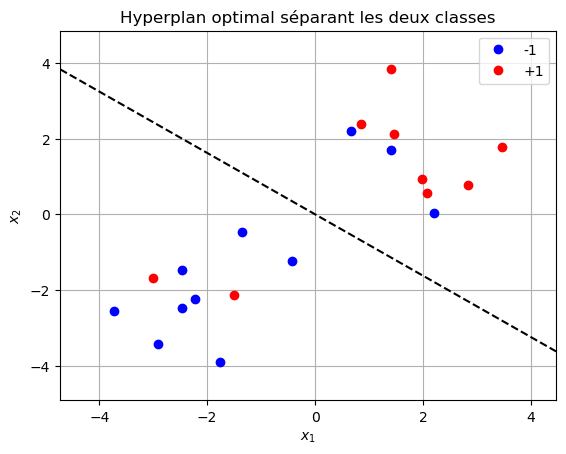

In [60]:
SVMhardmarginloss = SVMHardMarginLoss(points, labels, 0.1, 1000)
SVMhardmarginloss.run_and_plot()

L'hyperplan obtenu avec la SVM à marge rigide avec Hard Margin Loss est donné par l'équation $0.52x + 0.64y + 0.00 = 0$.
Fait intéressant, cet hyperplan est identique à celui obtenu avec la SVM à marge rigide classique. Cependant, étant donné que les points ne sont pas linéairement séparables, la SVM à marge rigide classique n'aurait pas été en mesure de fournir une solution (comme expliqué précédemment).

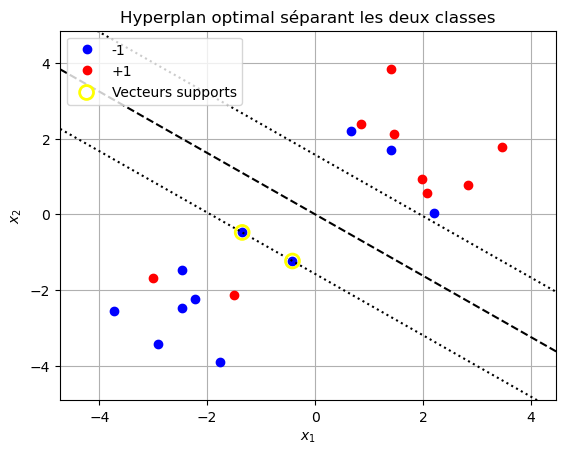

In [61]:
SVMhardmarginloss.plot_results(plot_marge=True, plot_support_vectors=True)

### Analyse quantitative de l'effet de $C$ sur le plan optimal dans le cadre de la SVM avec *Hard Margin Loss*

Nous allons réaliser la démarche analogue à celle réalisée dans le cadre de l'analyse quantitative de l'effet de $C$ sur le plan optimal dans le cadre de la SVM avec *Hard Margin Loss*.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

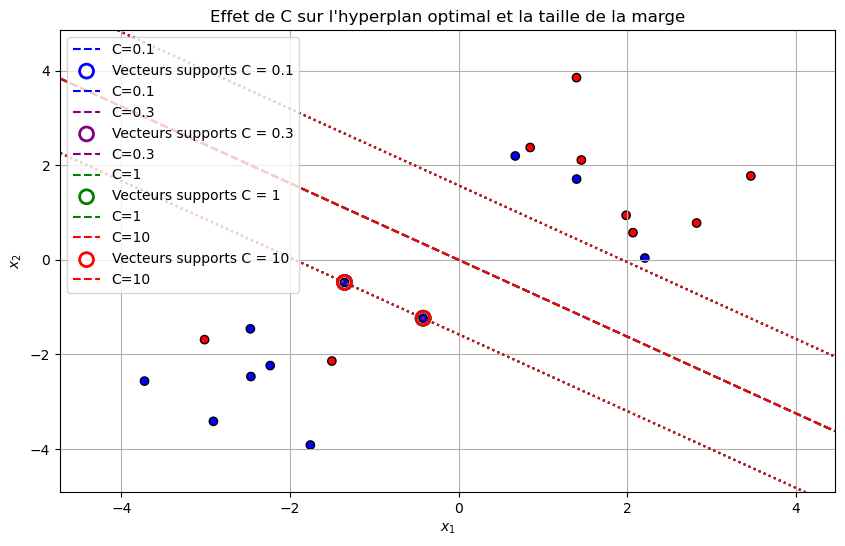

In [62]:
C_values = [0.1, 0.3, 1, 10]
colors = ["blue", "purple", "green", "red"]
trained_models, errors = SVMhardmarginloss.train_multiple_models(
    points, labels, C_values
)
SVMhardmarginloss.plot_C_variation(trained_models, C_values, colors, plot_marge=True, plot_support_vectors=True)

L'hyperplan obtenu est le même quelque soit les valeurs prises par $C$ ($0.1$ , $0.3$, $1$ et $10$).

Nous allons donc affiner ces valeurs pour vérifier qu'à mesure que la valeur de $C$ augmente, la frontière de décision diminue (comme c'est le cas pour les autres modèles préalablement exposés).

Ainsi, nous allons exploiter les valeurs de $C$ suivantes : $00.4$ , $0.1$, $1$ et $10$.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

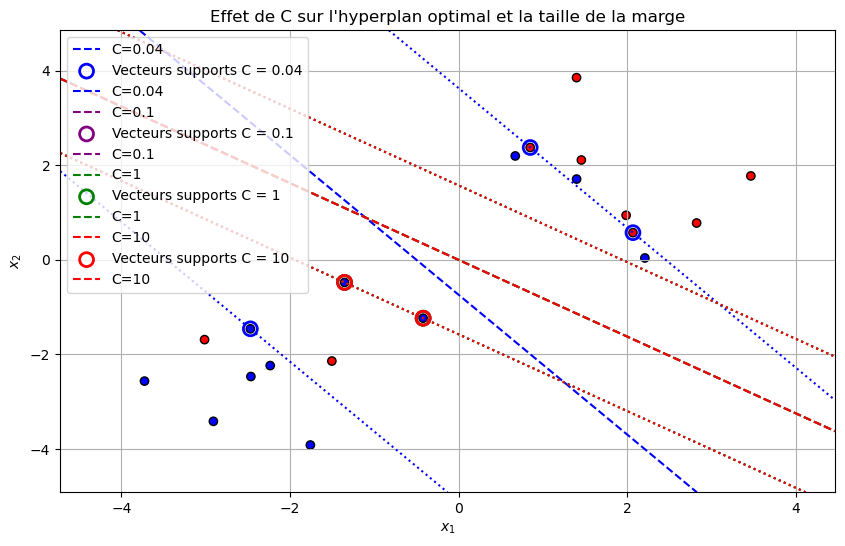

In [63]:
C_values = [0.04, 0.1, 1, 10]
colors = ["blue", "purple", "green", "red"]
trained_models, errors = SVMhardmarginloss.train_multiple_models(
    points, labels, C_values
)
SVMhardmarginloss.plot_C_variation(trained_models, C_values, colors, plot_marge=True, plot_support_vectors=True)

Nous observons qu’avec $C = 0.04$, la frontière de décision est plus large, ce qui permet une plus grande tolérance aux erreurs. En revanche, à partir de $C = 0.1$ et jusqu'à $C = 10$, l’hyperplan reste identique mais devient moins étendu, indiquant une réduction de la tolérance aux erreurs par rapport à $C = 0.04$. 

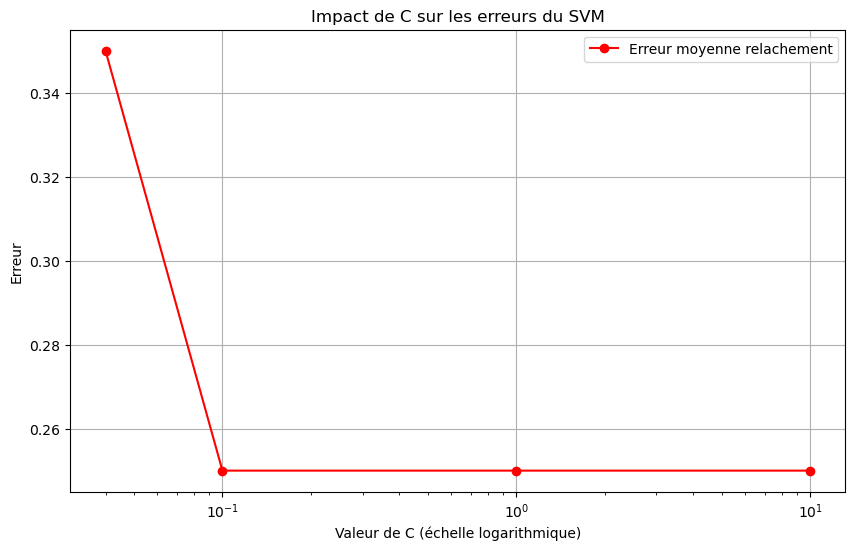

In [64]:
SVMhardmarginloss.plot_svm_errors(
    C_values=C_values,
    errors=errors,
    plot_taux_erreurs=False,
    plot_mean_relachement=True,
)

Pour $C = 0.04$, l'erreur est plus élevée. En revanche, à partir de $C=0.1$ et jusqu'à $C=10$, l'erreur reste constante mais à un niveau plus faible qu'avec $C=0.04$.

## Comparaison des modèles de SVM

Nous allons comparer les performances des différents modèles de SVM implémentés.

Pour cela, nous allons effectuer un raisonnement analogue à ceux réalisés précédemment pour chacun des modèles. Mais pour cela nous utiliserons un jeu de données beaucoup plus important et, dans le cadre de la compraison des erreur, nous utiliserons exclusivement le taux d'erreurs des points mal classés, définis dans la classe abstraite `SVMBase`, qui, pour rappel, s'exprime ainsi : $\frac{\sum\limits_{i=1}^{n} \mathbb{1}_{y_i \times (w_{1} x_{i, 1} + w_{2} x_{i, 2} + w_{3}) \; < \; 0}}{n} \times 100$.

Cela permettra de disposer d'un élément commun à chaque modèle pour les comparer.

Nous allons générer un *dataset* de 500 points avec du bruit.

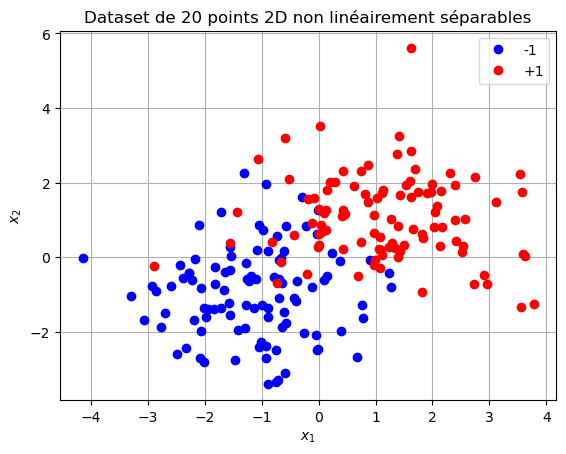

In [65]:
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt

# Générer des données gaussiennes
n_samples = 200  # Nombre de points
centers = [(-1, -1), (1, 1)]  # Centres des clusters
X, y = make_blobs(
    n_samples=n_samples, centers=centers, cluster_std=1.2, random_state=42
)

# Convertir les labels pour correspondre aux SVM (-1 et 1)
y = np.where(y == 0, -1, 1)

# Stocker dataset sous forme de tableau numpy pour les classes SVM
points, labels = X, y

# Affichage du nouveau dataset
plt.plot(
    points[:, 0][labels == -1], points[:, 1][labels == -1], "bo", label="-1"
)  # Cercles bleus pour -1
plt.plot(
    points[:, 0][labels == 1], points[:, 1][labels == 1], "ro", label="+1"
)  # Cercles rouges pour +1
plt.title("Dataset de 20 points 2D non linéairement séparables")
plt.xlabel(r"$x_{1}$")
plt.ylabel(r"$x_{2}$")
plt.grid()
plt.legend()
plt.show()

Nous allons ensuite entraîner les différents modèles de SVM sur ce jeu de données et comparer leurs performances avec la même valeur de $C = 1$.

In [66]:
# Liste des modèles SVM à tester
svm_models = {
    "Hinge Loss": SVMHingeLoss(points, labels, C=1),
    "Ramp Loss": SVMRampLoss(points, labels, C=1, M=1000),
    "Hard Margin Loss": SVMHardMarginLoss(points, labels, C=1, M=1000),
}

# Entraînement des modèles et calcul du taux d'erreur
errors = {}

for name, model in svm_models.items():
    model.train_model()
    model.compute_errors()
    errors[name] = {"error rate" : model.errors["error rate"], "misclassified points" : model.errors["misclassified points"]}

# Affichage des résultats
for name, error in errors.items():
    print(
        f"{name}: {error.get('misclassified points')} points mal classés, {error.get('error rate')}% d'erreurs"
    )

Hinge Loss: 19 points mal classés, 9.5% d'erreurs
Ramp Loss: 19 points mal classés, 9.5% d'erreurs
Hard Margin Loss: 19 points mal classés, 9.5% d'erreurs


Avec le jeu de données généré, nous obtenons les mêmes résultats indépendamment du modèle choisi : 19 points mal classés et 9,5 % d'erreur.

Ce résultat peut s'expliquer par les quatre éléments suivants :
1. Le dataset est trop simple pour faire apparaître les différences. Les classes étant presque linéairement séparables, les trois modèles trouvent la même frontière optimale : ce choix a été fait pour garantir un temps d'exécution suffisamment faible. Dans ce cas, les erreurs viennent seulement des points dans la marge ou des outliers, donc le taux d'erreur est similaire.

2. Dans le cadre de nos modèles, la régularisation L1, qui est la somme des valeurs absolues des poids, force plusieurs coefficients à zéro. Cela peut pousser tous les modèles à converger vers une solution très proche : ce qui est cohérent avec le *dataset* choisi qui ne présente pas de vrai dilemme de classification ;

3. La valeur de $C = 1$ utilisée est trop faible. En effet, la pénalisation des erreurs dans *Hinge Loss* et *Ramp Loss* n'est pas très forte.

4. La valeur de $M = 1000$ étant très élevée, les variables binaires $z_{i}$ forcent les points avec $\epsilon_{i} > 1$ à être comptés comme une erreur complète, ce qui peut rendre *Ramp Loss* équivalent à *Hinge Loss* dans certaines conditions.

Nous allons pousser plus loin notre analyse en diminuant $M$ pour les modèle *Hinge Loss* *Ramp Loss* puisque pour $M=1000$ cette distinction n'est pas suffisante. Et d'autre part augmenter la valeur de $C$ pour voir si les erreurs des modèles *Hinge Loss* et *Ramp Loss* diminuent contrairement à *Ramp Loss* qui reste stable.

### Analyse quantitative de $M$ sur les erreurs des modèles *Hinge Loss* et *Ramp Loss*

Nous allons utiliser les valeurs de $M$ suivantes : $[1, 10, 1000]$ et $C=1$ dans les modèles *Ramp Loss* et *Hard Margin Loss* et comparer leur résultat.

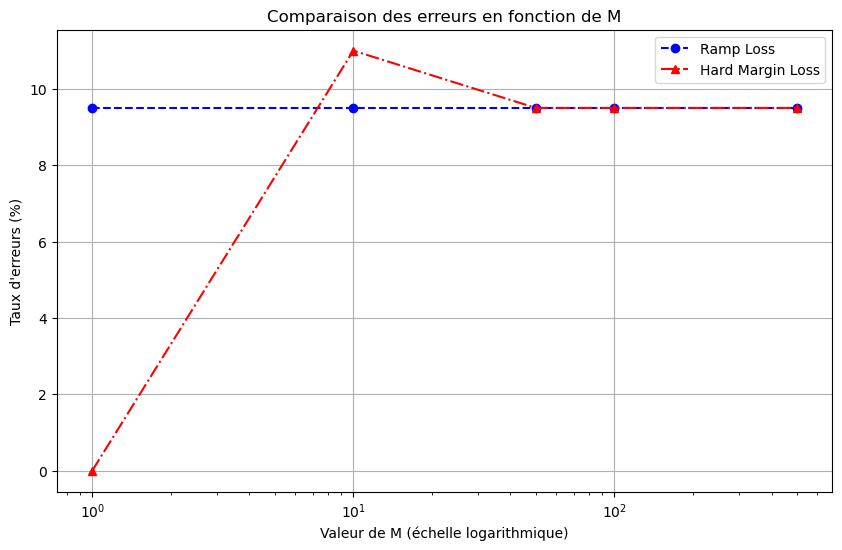

In [67]:
M_values = [1, 10, 50, 100, 500]
C_value = 1
results = {name: [] for name in svm_models.keys()}

errors = []

for M in M_values:
    errors_current_M = {}
    for name, model in svm_models.items():
        if name in ["Ramp Loss", "Hard Margin Loss"]:
            model = svm_models[name].__class__(points, labels, C=C_value, M=M)
        model.train_model()
        model.compute_errors()
        errors_current_M[name] = model.errors["error rate"]
    errors.append(errors_current_M)

# Extraire les valeurs des erreurs pour chaque type de perte
ramp_loss_errors = [err["Ramp Loss"] for err in errors]
hard_margin_errors = [err["Hard Margin Loss"] for err in errors]

# Tracer le graphique
plt.figure(figsize=(10, 6))

plt.plot(
    M_values,
    ramp_loss_errors,
    marker="o",
    linestyle="--",
    label="Ramp Loss",
    color="blue",
)
plt.plot(
    M_values,
    hard_margin_errors,
    marker="^",
    linestyle="-.",
    label="Hard Margin Loss",
    color="red",
)

# Utilisation d'une échelle logarithmique pour M
plt.xscale("log")
plt.xlabel("Valeur de M (échelle logarithmique)")
plt.ylabel("Taux d'erreurs (%)")
plt.title("Comparaison des erreurs en fonction de M")
plt.legend()
plt.grid(True)
plt.show()

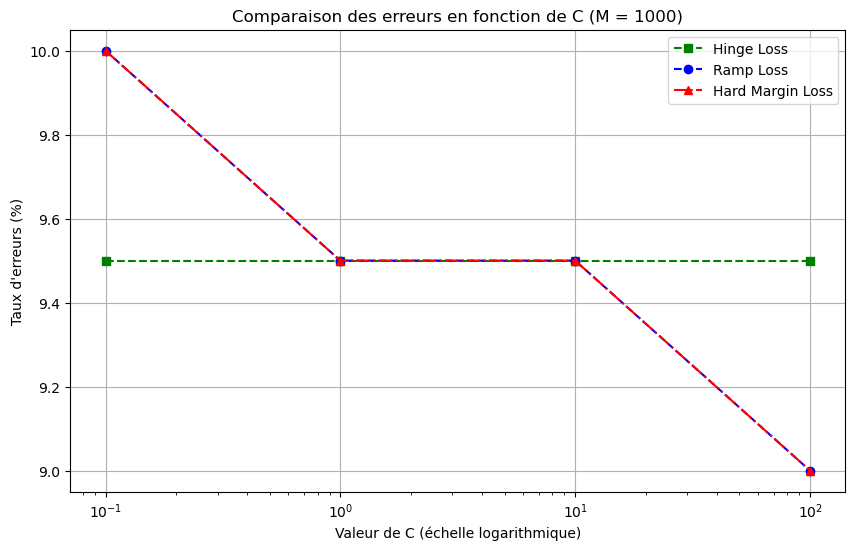

In [68]:
M_value = 1000
C_values = [0.1, 1, 10, 100]
results = {name: [] for name in svm_models.keys()}

errors = []

for C in C_values:
    errors_current_C = {}
    for name, model in svm_models.items():
        if name in ["Hinge Loss"]:
            model = svm_models[name].__class__(points, labels, C=C)
        elif name in ["Ramp Loss", "Hard Margin Loss"]:
            model = svm_models[name].__class__(points, labels, C=C, M=M_value)
        model.train_model()
        model.compute_errors()
        errors_current_C[name] = model.errors["error rate"]
    errors.append(errors_current_C)

# Extraire les valeurs des erreurs pour chaque type de perte
hinge_loss_errors = [err["Hinge Loss"] for err in errors]
ramp_loss_errors = [err["Ramp Loss"] for err in errors]
hard_margin_errors = [err["Hard Margin Loss"] for err in errors]

# Tracer le graphique
plt.figure(figsize=(10, 6))


plt.plot(
    C_values,
    hinge_loss_errors,
    marker="s",
    linestyle="--",
    label="Hinge Loss",
    color="green",
)
plt.plot(
    C_values,
    ramp_loss_errors,
    marker="o",
    linestyle="--",
    label="Ramp Loss",
    color="blue",
)
plt.plot(
    C_values,
    hard_margin_errors,
    marker="^",
    linestyle="-.",
    label="Hard Margin Loss",
    color="red",
)

# Utilisation d'une échelle logarithmique pour M
plt.xscale("log")
plt.xlabel("Valeur de C (échelle logarithmique)")
plt.ylabel("Taux d'erreurs (%)")
plt.title("Comparaison des erreurs en fonction de C (M = 1000)")
plt.legend()
plt.grid(True)
plt.show()

La figure ci-dessus montre bien qu'à mesure que $C$ augmente, le nombre d'erreurs diminue.
Cela est en accord avec les analyses précédentes.

## Conclusion

L’étude menée sur les différentes variantes des **Machines à Vecteurs de Support (SVM)** met en évidence les forces et les limites des approches utilisées. Le **SVM à marge rigide classique** offre de **très bonnes performances** lorsque les données sont **linéairement séparables**, mais il **échoue** dans le cas contraire, ne trouvant alors **aucune solution**. Pour pallier ce problème, l’introduction de la **régularisation** permet d’assouplir les contraintes et d’obtenir des solutions adaptées aux données **non linéairement séparables**.  

L’utilisation de **la hinge loss et de la ramp loss** a également prouvé son efficacité, fournissant des résultats cohérents avec l’objectif de maximisation de la marge tout en gérant les erreurs de classification.  

Enfin, l’impact du **paramètre de régularisation $C$** a été analysé pour chaque modèle. Il a été démontré que **plus $C$ est élevé, plus la marge d’erreur diminue**, rendant le modèle plus strict dans sa séparation des classes. Cependant, **une valeur trop élevée de $C$ entraîne un risque de surapprentissage**, compromettant ainsi la généralisation du modèle sur de nouvelles données.  

En conclusion, le choix du modèle et de ses hyperparamètres doit être **adapté aux données** afin de garantir un **équilibre optimal entre précision et généralisation**.
